# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                  - X_train_ifidf
                  - X_train_vocab_ifidf
                  - X_train_dist_ifidf
                  - y_train_ifidf
                  - y_train_vocab_ifidf
                  - y_train_dist_ifidf
                  

    - Analyse multivarié 
    **QUESTION : Peut-on considérer LDA comme analyse multivariée ?**
    
    
    - Réduction de dimensions
    **QUESTION : Peut-on faire un word2vec ?**
    
    
        

# Chargement de bibliothéques

In [1]:
# Import the libraries
import joblib
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
import re

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 

# Libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

Les données était récupérées de stack overflow à l'aide de code suivant :

SELECT body, title, tags FROM posts 
WHERE title is not null and body is not null and tags is not null and id < 500000


In [4]:
data_load = pd.read_csv(
    'Data/data_text.csv', sep=',')

In [5]:
data_load.shape

(50000, 3)

In [6]:
data_load.head()

title  \
0                          Convert Decimal to Double   
1  Percentage width child element in absolutely p...   
2            How do I calculate someone's age in C#?   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                body  \
0  <p>I want to use a track-bar to change a form'...   
1  <p>I have an absolutely positioned <code>div</...   
2  <p>Given a <code>DateTime</code> representing ...   
3  <p>Given a specific <code>DateTime</code> valu...   
4  <p>Is there a standard way for a web server to...   

                                                tags  
0  <c#><floating-point><type-conversion><double><...  
1                   <html><css><internet-explorer-7>  
2                               <c#><.net><datetime>  
3  <c#><datetime><time><datediff><relative-time-s...  
4  <html><browser><timezone><user-agent><timezone...

Exemple de la première question:

In [7]:
print (data_load['body'][2])

<p>Given a <code>DateTime</code> representing a person's birthday, how do I calculate their age in years?  </p>



## Création d'un jeu de données test

Notre variable cible est la variable tags. Nous avons deux variables texte qui nous permettrons estimer le tag : variables title et body. Nous allons séparer 30 % de données qui seront utilisées plus tard afin de tester les modèles :

In [8]:
target = data_load['tags']

In [9]:
data=data_load.drop(['tags'], axis=1)

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.3, random_state=1)

In [13]:
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 35000 observations et 2 features.
Le vecteur y_train contient 35000 observations.
Le jeu de données X_test contient 15000 observations et 2 features.
Le vecteur y_test contient 15000 observations.


Exporter les jeux do données en .csv

In [14]:
X_train.to_csv('Data/X_train.csv', sep='\t')
X_test.to_csv('Data/X_test.csv', sep='\t')
y_train.to_csv('Data/y_train.csv', sep='\t', header=False)
y_test.to_csv('Data/y_test.csv', sep='\t', header=False)

# Data cleaning 

## Tester les fonctions sur un exemple de features

### Enlever les balises html

Pour enlever les balises HTML, nous allons utiliser le package BeautifulSoup:

In [16]:
# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(X_train['body'][0])  

# Print the raw review and then the output of get_text(), for 
# comparison
print (X_train['body'][0])
print (example1.get_text())

<p>I want to use a track-bar to change a form's opacity.</p>

<p>This is my code:</p>

<pre><code>decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;
</code></pre>

<p>When I build the application, it gives the following error:</p>

<blockquote>
  <p>Cannot implicitly convert type <code>decimal</code> to <code>double</code></p>
</blockquote>

<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>

I want to use a track-bar to change a form's opacity.
This is my code:
decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;

When I build the application, it gives the following error:

Cannot implicitly convert type decimal to double

I tried using trans and double but then the control doesn't work. This code worked fine in a past VB.NET project.



### Enlever la ponctuation

Nous allons enlever la ponctuation tout en gardant les nombres, lettres ainsi que les signes "-", "+" et "#" étant donné que ces signes sont souvent utilisés dans l'informatique. 

In [22]:
letters_only = re.sub("[^0-9#+a-zA-Z]",       # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

I want to use a track bar to change a form s opacity  This is my code  decimal trans   trackBar1 Value   5000  this Opacity   trans   When I build the application  it gives the following error   Cannot implicitly convert type decimal to double  I tried using trans and double but then the control doesn t work  This code worked fine in a past VB NET project  


### Mise en minuscule et tokenization

In [23]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words

### Stopwords

In [24]:
# Let's have a look to the stopwords from ntlk.corpus
print (stopwords.words("english")) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [25]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['want', 'use', 'track', 'bar', 'change', 'form', 'opacity', 'code', 'decimal', 'trans', 'trackbar1', 'value', '5000', 'opacity', 'trans', 'build', 'application', 'gives', 'following', 'error', 'cannot', 'implicitly', 'convert', 'type', 'decimal', 'double', 'tried', 'using', 'trans', 'double', 'control', 'work', 'code', 'worked', 'fine', 'past', 'vb', 'net', 'project']


## Tester les fonctions sur un exemple de targets

Les tags (notre variable cible) ont une forme spécifiques. Les mots sont entre "<>". Les tags sont parfois composés par deux, voir plusieurs mots qui sont séparés par "-". Nous allons enlever les balises.

In [27]:
#Take the first tag from the dataset
tag = y_train[0]

In [28]:
#Check
tag

'<c#><floating-point><type-conversion><double><decimal>'

In [29]:
#Remove first '<'
tag = tag[1:]

In [30]:
#Check
tag

'c#><floating-point><type-conversion><double><decimal>'

In [31]:
#Remove last '>'
tag = tag[:-1]

In [32]:
#Check
tag

'c#><floating-point><type-conversion><double><decimal'

In [33]:
#Remove remaining '><' signs
tag = tag.split('><')

In [34]:
#Check
tag

['c#', 'floating-point', 'type-conversion', 'double', 'decimal']

In [35]:
#Converting back to string
tag_clean = " ".join(tag)  

In [36]:
#Check
tag_clean

'c# floating-point type-conversion double decimal'

## Pipelines pour data cleaning

### Features

Nous allons utiliser la fonction suivante pour automatiser le processus de data cleaning :

In [37]:
def review_to_words( raw_review ):
    """Function to convert a raw review to a string of words
    The input is a single string (a raw movie review), and 
    the output is a single string (a preprocessed movie review)"""
    
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^0-9#-+a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [38]:
X_train['body_clean']=X_train['body'].apply(lambda x: review_to_words(x))

In [39]:
X_train['title_clean']=X_train['title'].apply(lambda x: review_to_words(x))

In [40]:
X_train.head()

title  \
8950   Which Rails plug in is best for role based per...   
38421                   How do I build a VB6 Console App   
19363                 How to "inverse match" with regex?   
30157  How to host multiple webapps using only 2 Virt...   
14294                                   Modular web apps   

                                                    body  \
8950   <p>I need to add role based permissions to my ...   
38421  <p>I did some googling to try to answer this q...   
19363  <p>I'm using RegexBuddy but I'm in trouble any...   
30157  <p>my shared hosting only allows me to create ...   
14294  <p>I've been looking into <a href="http://www....   

                                              body_clean  \
8950   need add role based permissions rails applicat...   
38421  googling try answer question even i'm quite cl...   
19363  i'm using regexbuddy i'm trouble anyway thing ...   
30157  shared hosting allows create 2 virtual directo...   
14294  i've looking osgi recently think looks like re...   

                                             title_clean  
8950   rails plug best role based permissions (please...  
38421                              build vb6 console app  
19363                                inverse match regex  
30157  host multiple webapps using 2 virtual directories  
14294                                   modular web apps

Nous allons aussi construire une fonction qui nous servira comme paramètre de tokenizer personnalisé que nous allons appliquer dans l'outil CountVectorizer, afin de garder la structure de bigrams que l'on a créé pendant la transformation de features. Nous allons séparer les mot tout simplement en utilisant méthode .split() qui sépare les mots par espace et laisse les caractères spéciaux comme par exemple '#' collé sur les mots, contrairement à la méthode .tokenize() 

In [41]:
def my_tokenizer(doc):
    
    """Function defining personalized tokenizer for sklearn's CountVectorizer in order to keep the created 
    bigrams in tag's format.
    
    Input:
    
    - doc : string to be tokenized
    
    Output:
    
    - tokenized string
    """
    
    
    tokens = doc.split()
    
    return tokens

Nous allons définir les stop-words que nous n'avons pas enlevé dans l'étape de cleaning, mais qui figurent souvent dans les posts et qui n'ont pas de valeur informative. La liste sera également utilée en paramètre de CountVectorizer et TfidfVectorizer.

In [78]:
stop_words = ["i'm", 'would', '1', '0', '2', "i've", 'could', 'anyone', 'also', '3', 'thanks', 
               'two', 'however', "i'd", '5', "+", "#", "im", "ive", "dont", "cant", "id", ")", "("]

### Target

In [43]:
def cleaning_target(raw_target):
    """Function to remove '<>' signs from target list and to replace them with a space
    
    Arguments :
    - raw_target : a Series of tags
    
    Return :
    - Series with cleaned tags
       
    """
    
    #Remove first '<'
    tag = raw_target[1:]
    
    #Remove last '>'
    tag = tag[:-1]
    
    #Remove remaining '><' signs
    tag = tag.split('><')
    
    #Converting back to string
    tag_clean = " ".join(tag)  
    
    return tag_clean

In [44]:
y_train_clean=y_train.apply(lambda x: cleaning_target(x))

In [45]:
y_train_clean.head()

8950                            ruby-on-rails
38421                      winapi vb6 console
19363                     regex inverse-match
30157                   iis virtual-directory
14294    java web-applications jsf modularity
Name: tags, dtype: object

# Feature engineering

## Créer les bigrams

Nous allons créer des bigrams, car les tags sont souvent composés par deux mots, séparés par "-". Les bigrams créé à partir de text de body et title vont donc être mis au même format que les tags.

### Tester les fonctions sur un exemple de post

In [46]:
#Take the first element of the cleaned body text
body = X_train['body_clean'][0]

In [47]:
#Split it to a list of words
body = body.split()

In [48]:
#Check
body[:10]

['want',
 'use',
 'track',
 'bar',
 'change',
 "form's",
 'opacity',
 'code',
 'decimal',
 'trans']

In [49]:
#Creating bigrams object
bigram = nltk.bigrams(body)

In [50]:
#Creating a list of bigram objects
liste = list(bigram)

In [51]:
#Check
liste[:10]

[('want', 'use'),
 ('use', 'track'),
 ('track', 'bar'),
 ('bar', 'change'),
 ('change', "form's"),
 ("form's", 'opacity'),
 ('opacity', 'code'),
 ('code', 'decimal'),
 ('decimal', 'trans'),
 ('trans', 'trackbar1')]

In [52]:
#Creating a tag-like word from tuples
bigrams_rec = []

for i in range(len(liste)):
    tuple1 = liste[i]
    elt = tuple1[0] + '-' + tuple1[1]
    bigrams_rec.append(elt)

In [53]:
#Creating a string from list of tag-like bigrams
bigrams_str = " ".join(bigrams_rec)

### Créer des pipelines pour le recodage en bigrams

Nous allons utiliser deux fonctions afin de :
    1. créer les bigrams
    2. recoder les bigrams dans le même format comme les tags dans notre variable cible

In [54]:
def create_bigrams(var):
    
    """Function which generates a liste of tuples representing bigrams. 
    
    Arguments :
    - var : feature to be recoded
    
    Returns :
    - a Series of recoded feature  
    
    """
   
   #Take the i-th element of the cleaned body text
    body = var    
        
    #Split it to a list of words
    body = body.split()
    
    #Creating bigrams object
    bigram = nltk.bigrams(body)
    
    #Creating a list of bigram objects 
    liste_bigram = list(bigram)
        
        
    return liste_bigram

In [55]:
X_train['body_bigram'] = X_train['body_clean'].apply(lambda x : create_bigrams(x))

In [56]:
X_train['body_bigram'].head()

8950     [(need, add), (add, role), (role, based), (bas...
38421    [(googling, try), (try, answer), (answer, ques...
19363    [(i'm, using), (using, regexbuddy), (regexbudd...
30157    [(shared, hosting), (hosting, allows), (allows...
14294    [(i've, looking), (looking, osgi), (osgi, rece...
Name: body_bigram, dtype: object

In [57]:
def recode_bigrams(liste):
    """Function which recode the bigrams generated by recode_bigram function.
    Each bigram has the same structure as the stack overflow tages :
    it is composed of two words and the words are separated by '-'  
    
    Arguments :
    - liste : a liste containing bigram tuples
    
    Return :
    
    - a string of recoded bigrams_rec
    """
    
    #Creating a tag-like word from tuples
    bigrams_rec = []

    for i in range(len(liste)):
        tuple1 = liste[i]
        elt = tuple1[0] + '-' + tuple1[1]
        bigrams_rec.append(elt)
        
    return " ".join(bigrams_rec)

In [58]:
X_train['body_bigram_clean'] = X_train['body_bigram'].apply(lambda x : recode_bigrams(x))

In [59]:
X_train['body_bigram_clean'].head()

8950     need-add add-role role-based based-permissions...
38421    googling-try try-answer answer-question questi...
19363    i'm-using using-regexbuddy regexbuddy-i'm i'm-...
30157    shared-hosting hosting-allows allows-create cr...
14294    i've-looking looking-osgi osgi-recently recent...
Name: body_bigram_clean, dtype: object

Nous allons appliquer les mâmes fonctions sur la feature title :

In [60]:
X_train['title_bigram'] = X_train['title_clean'].apply(lambda x : create_bigrams(x))

In [61]:
X_train['title_bigram_clean'] = X_train['title_bigram'].apply(lambda x : recode_bigrams(x))

In [62]:
X_train['title_bigram_clean'].head()

8950     rails-plug plug-best best-role role-based base...
38421                    build-vb6 vb6-console console-app
19363                            inverse-match match-regex
30157    host-multiple multiple-webapps webapps-using u...
14294                                 modular-web web-apps
Name: title_bigram_clean, dtype: object

### Fusionner le title, body et les bigrams

Afin de simplifier le travail exploratiore et les recodages de text qui va être utilisé dans la partie analyse, nous allons créer une feature unique composée par le text de title, de body et des bigrams créés à partir de ces deux features :

In [63]:
X_train['post'] = X_train['title_clean'] + " " + X_train['body_clean'] + " " + X_train['body_bigram_clean'] + " " + X_train['title_bigram_clean']  

In [64]:
X_train['post'].head()

8950     rails plug best role based permissions (please...
38421    build vb6 console app googling try answer ques...
19363    inverse match regex i'm using regexbuddy i'm t...
30157    host multiple webapps using 2 virtual director...
14294    modular web apps i've looking osgi recently th...
Name: post, dtype: object

In [65]:
X_train['post'][0]

"convert decimal double want use track bar change form's opacity code decimal trans trackbar1 value 5000 opacity trans build application gives following error cannot implicitly convert type decimal double tried using trans double control work code worked fine past vb net project want-use use-track track-bar bar-change change-form's form's-opacity opacity-code code-decimal decimal-trans trans-trackbar1 trackbar1-value value-5000 5000-opacity opacity-trans trans-build build-application application-gives gives-following following-error error-cannot cannot-implicitly implicitly-convert convert-type type-decimal decimal-double double-tried tried-using using-trans trans-double double-control control-work work-code code-worked worked-fine fine-past past-vb vb-net net-project convert-decimal decimal-double"

# Analyse exploratoire

## Analyses univariées

### Description générale

Nous allons tout d'abord étudier la longueur de notre chaîne de caractère de post, ainsi que le nombre de tags attribué à chaque post :

In [66]:
nbr_mots = X_train['post'].apply(lambda row : len(row.split()))

In [67]:
nbr_mots.describe()

count    35000.000000
mean       140.910743
std        143.811216
min          2.000000
25%         64.000000
50%        104.000000
75%        172.000000
max       5584.000000
Name: post, dtype: float64

Feature post, qui contient le titre, le corps de post et les bigrams créés à partir de titre et le corps de post, contient en moyen 140 mots. Le minimum est 2 mots et le maximum 5 584 mots.


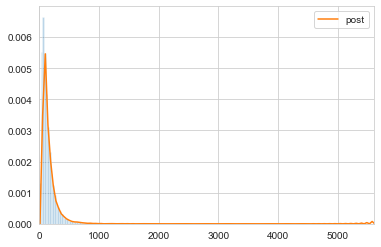

In [68]:
#!!! Améliorer le graphique pour la présentation
plt.hist(nbr_mots, alpha=0.3, range=(
    0, 5600),  bins=200, density=True)
sns.kdeplot(nbr_mots)

plt.xlim(0, 5600)
plt.rcParams['figure.figsize'] = (20, 20)

In [69]:
y_train_clean.head()

8950                            ruby-on-rails
38421                      winapi vb6 console
19363                     regex inverse-match
30157                   iis virtual-directory
14294    java web-applications jsf modularity
Name: tags, dtype: object

In [70]:
nbr_tags = y_train_clean.apply(lambda row : len(row.split()))

In [71]:
nbr_tags.describe()

count    35000.000000
mean         2.915629
std          1.125359
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: tags, dtype: float64

Le nombre de tags varie de 1 à 6 avec la valeurs médiane de 3 tags par post.

### Bag of words

Nous allons transformer les données text en matrice creuse, appelée Bag-of-Words, qui indique le nombre d'apparitions d'un mot dans la chaîne de caractères. A l'aide de cette transformation, nous allons pouvoir effectuer des opérations numériques sur les chaînes de caractères, notamment calculer des caractéristiques univariées telles que fréquences.  


La matrice représentant Bag-of-Words contient autant de colonnes que le nombre de mots dans le corpus (ensemble de posts dans notre cas). Nous allons utiliser une option max_features = 50 000 qui limite le nombre de features à 50 000.

#### Feature

In [79]:
#!!! Ajouter une fct qui mesure le tps d'exécution ???
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 50000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_train_bow = vectorizer.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_bow = X_train_bow.toarray()

Creating the bag of words...



In [80]:
X_train_bow.shape

(35000, 50000)

In [81]:
# Take a look at the words in the vocabulary
X_train_vocab_bow = vectorizer.get_feature_names()
print (X_train_vocab_bow)

['##', '###', '####', '#####################################################################', '##dispatcher', '#-#', '#-1', '#-bin', '#-class', '#-code', '#-create', '#-define', '#-end', '#-file', '#-files', '#-foo', '#-get', '#-id', '#-include', '#-line', '#-mybean', '#-name', '#-onclick', '#-self', '#-something', '#-usr', '#0', '#0-0', '#0-1', '#000', '#000000', '#000000-1px', '#1', '#2', '#3', '#333333', '#4', '#5', '#6', '#666666', '#8', '#990000', '#990000-face', '#basic', '#ccc', '#chooser', '#chooser-nav', '#content', '#define', '#defines', '#else', '#endif', '#endregion', '#error', '#event', '#event-values', '#f)', '#f)-((eq', '#f00', '#ff0000', '#ff0000-b', '#ff0000-font', '#fff', '#ffffff', '#if', '#ifdef', '#ifndef', '#import', '#include', '#include-boost', '#include-iostream', '#include-stdio', '#include-stdlib', '#include-string', '#include-vector', '#includes', '#main', '#nav', '#nav-ul', '#photo', '#photo-)', '#pragma', '#region', '#t', '#tmp', '#tooltip', '#tooltip-)',

In [82]:
# !!! Temps d'exécution !!!
# Sum up the counts of each vocabulary word
X_train_dist_bow = np.sum(X_train_bow, axis=0)

In [76]:
# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(X_train_vocab_bow, X_train_dist_bow):
    print (count, tag)

48 ##
10 ###
8 ####
10 #####################################################################
8 ##dispatcher
130 #-#
7 #-0
9 #-1
36 #-bin
18 #-class
9 #-code
9 #-create
13 #-define
8 #-end
8 #-file
8 #-files
11 #-foo
8 #-get
12 #-id
11 #-include
12 #-line
8 #-mybean
8 #-name
23 #-onclick
7 #-output
17 #-something
44 #-usr
46 #0
11 #0-0
9 #0-1
13 #000
27 #000000
12 #000000-1px
137 #1
112 #2
46 #3
23 #4
17 #5
10 #6
9 #8
35 #990000
35 #990000-face
19 #chooser
19 #chooser-nav
13 #content
131 #define
8 #defines
14 #else
44 #endif
25 #endregion
10 #error
26 #event
20 #event-values
43 #ff0000
15 #ff0000-b
19 #ff0000-font
11 #fff
24 #ffffff
29 #if
22 #ifdef
21 #ifndef
31 #import
337 #include
10 #include-boost
51 #include-iostream
32 #include-stdio
7 #include-stdlib
21 #include-string
7 #include-sys
8 #include-vector
10 #includes
7 #left
11 #main
10 #nav
8 #nav-ul
13 #photo
13 #photo-)
22 #pragma
32 #region
7 #right
9 #t
12 #tmp
11 #tooltip
9 #tooltip-)
10 #warning
1065 $
7 $#
14 $$
8 $&'()*+
14

10 )-continue
24 )-could
8 )-course
17 )-cout
48 )-create
14 )-css(
10 )-currently
22 )-data
9 )-database
10 )-date
8 )-dbms
7 )-dc
12 )-def
7 )-default
11 )-delete
10 )-description
7 )-die
14 )-dim
9 )-div
9 )-doc
10 )-document
7 )-done
12 )-e
7 )-easy
16 )-echo
106 )-edit
9 )-elements(
65 )-else
97 )-end
13 )-engine
19 )-error
9 )-etc
12 )-even
7 )-every
21 )-example
7 )-except
18 )-f
8 )-fails
21 )-file
14 )-final
9 )-finally
9 )-find
17 )-first
10 )-float
8 )-following
8 )-foo
18 )-foreach
11 )-form
14 )-found
34 )-function
68 )-get
11 )-gives
32 )-go
19 )-good
12 )-handle
22 )-header(
10 )-help
18 )-here's
11 )-hide()
61 )-however
16 )-html
29 )-i'd
102 )-i'm
60 )-i've
11 )-idea
18 )-ideas
29 )-if(
7 )-imagine
9 )-import
15 )-innerhtml
7 )-input
17 )-insert
7 )-inside
12 )-instead
36 )-int
13 )-key
43 )-know
8 )-let
7 )-like
13 )-line
33 )-list
8 )-load
13 )-logger
7 )-long
10 )-looking
10 )-looks
11 )-main
17 )-make
8 )-makes
7 )-many
7 )-may
7 )-mean
15 )-message
19 )-method
7 )

13 2b56-96345589d82b
149 2d
15 2d-array
12 2d-game
9 2d-graphics
11 2e
8 2e-00
8 2f
29 2gb
8 2gb-ram
16 2k
9 2k3
9 2k5
13 2mb
94 2nd
32 2px
10 3%
8 3'
261 3)
15 3)-null
32 3-)
9 3-*
8 3-+
336 3-0
17 3-0)
143 3-1
9 3-1)
14 3-10
119 3-2
10 3-2$
10 3-20
10 3-2008
82 3-3
267 3-4
11 3-4)
629 3-5
28 3-5)
26 3-6
21 3-7
12 3-8
20 3-b
14 3-c
11 3-classes
8 3-column
26 3-different
8 3-digits
10 3-fields
17 3-font
9 3-hours
10 3-html
9 3-items
31 3-lib
11 3-lines
10 3-n
8 3-option
8 3-possible
9 3-rows
8 3-safari
8 3-seconds
19 3-tables
11 3-tier
22 3-times
10 3-would
24 3-x
16 3-years
475 30
14 30%
31 30)
8 30-0
47 30-00
17 30-2008
8 30-60
16 30-days
21 30-minutes
35 30-seconds
122 300
10 300-width
10 300-wshshell
35 3000
9 30000
22 300px
48 301
12 301-redirect
16 302
10 303
14 304
12 3053
13 30729
30 30px
192 31
11 31)
15 31-*
13 31-00
12 31-08
8 31-2008
10 31bf3856ad364e35
552 32
11 32)
8 32-*
13 32-00
21 32-1
19 32-64
215 32-bit
9 32-bits
11 32-mscorlib
12 32-pm
16 320
63 32bit
8 32x32
82 33


15 also-could
9 also-create
14 also-created
9 also-curious
9 also-data
9 also-different
7 also-easy
9 also-fails
9 also-feel
7 also-file
11 also-find
10 also-fine
7 also-first
33 also-found
7 also-general
42 also-get
7 also-give
19 also-good
9 also-heard
11 also-help
11 also-i'd
27 also-i'm
11 also-i've
9 also-implement
13 also-important
18 also-include
9 also-installed
34 also-interested
9 also-interesting
43 also-know
89 also-like
8 also-list
14 also-looked
20 also-looking
8 also-looks
11 also-lot
12 also-made
21 also-make
7 also-many
21 also-means
12 also-mention
10 also-must
113 also-need
29 also-needs
7 also-net
20 also-nice
22 also-note
15 also-noticed
9 also-ok
16 also-one
11 also-open
10 also-option
7 also-pass
11 also-please
8 also-point
23 also-possible
8 also-provide
10 also-question
9 also-quite
18 also-read
15 also-really
7 also-receive
7 also-require
7 also-requires
15 also-run
22 also-see
31 also-seems
33 also-seen
21 also-set
8 also-show
7 also-since
8 also-sometimes
10

9 back-main
7 back-make
12 back-normal
8 back-old
11 back-one
32 back-original
18 back-page
11 back-parent
11 back-previous
7 back-question
11 back-response
48 back-server
8 back-sql
8 back-square
13 back-string
8 back-trunk
9 back-url
11 back-user
16 back-using
13 back-xml
24 backcolor
54 backed
187 backend
11 backend-database
9 backends
1071 background
11 background)
188 background-color
14 background-colors
21 background-i'm
56 background-image
10 background-images
9 background-info
10 background-information
13 background-position
8 background-process
9 background-red
29 background-thread
8 background-threads
15 background-transparent
8 background-using
15 background-value
18 backgroundcolor
15 backgrounds
44 backgroundworker
45 backing
17 backlabel
39 backlog
10 backs
14 backslash
13 backslashes
15 backspace
8 backticks
9 backtrace
326 backup
16 backup-database
12 backup-files
17 backup-restore
9 backup-sql
71 backups
10 backview
25 backward
12 backward-compatibility
59 backwards
1

12 called-within
93 caller
13 callers
9 callhandlerexecutionstep
9 callhandlerexecutionstep-system
12 callid
969 calling
15 calling-(methoddesc
8 calling-c#
22 calling-code
9 calling-convention
8 calling-external
32 calling-function
13 calling-get
30 calling-method
10 calling-methods
32 calling-mscorwks
10 calling-net
13 calling-ntdll
8 calling-page
9 calling-stored
8 calling-thread
13 calling-web
11 callingconvention
977 calls
10 calls)
9 calls-another
8 calls-back
14 calls-function
9 calls-javascript
8 calls-made
22 calls-method
9 calls-net
7 calls-silverlight
7 calls-use
12 calls-web
13 callstack
7 callvirt
7 cals
12 cam
363 came
105 came-across
7 came-back
13 came-following
8 came-mind
20 camel
14 camelcase
106 camera
10 cameras
28 caml
9 caml-query
10 camp
15 campaign
8 campo
3280 can't
33 can't-access
8 can't-actually
20 can't-add
16 can't-afford
9 can't-anything
16 can't-believe
16 can't-call
9 can't-cast
42 can't-change
28 can't-connect
7 can't-control
9 can't-convert
30 can't-

24 columns)
31 columns-asp
8 columns-column
10 columns-data
13 columns-database
17 columns-id
11 columns-need
8 columns-object
11 columns-one
8 columns-rows
33 columns-table
7 columns-type
8 columns-used
8 columns-using
10 columns-want
8 columns-would
3425 com
44 com'
11 com')
7 com's
59 com)
47 com+
16 com+-application
8 com-'
29 com-)
7 com-2
23 com-2006
11 com-2007
33 com-2008
8 com-80
18 com-api
7 com-app
9 com-apple
7 com-archive
7 com-article
17 com-articles
18 com-asm
7 com-au
13 com-b
22 com-blog
7 com-c
12 com-class
15 com-company
28 com-component
13 com-components
9 com-dcom
15 com-default
8 com-dll
15 com-download
7 com-downloads
87 com-en
9 com-error
31 com-example
13 com-file
15 com-folder1
23 com-foo
8 com-forum
8 com-forums
10 com-fwlink
8 com-get
14 com-getpaste
7 com-google
8 com-group
8 com-home
18 com-http
23 com-ibm
15 com-images
15 com-index
24 com-interface
7 com-interfaces
25 com-interop
7 com-jsp
35 com-kb
14 com-library
11 com-link
16 com-location
7 com-login
1

32 css-class
15 css-classes
8 css-code
10 css-etc
62 css-file
40 css-files
27 css-href
18 css-html
10 css-i'm
43 css-javascript
20 css-js
10 css-layout
10 css-link
8 css-property
25 css-rel
9 css-script
8 css-selector
9 css-solution
30 css-style
11 css-styles
8 css-table
10 css2
12 css3
68 cssclass
8 cssclass-grid
47 cstring
277 csv
104 csv-file
34 csv-files
8 csv-xs
31 ct
16 ct-report
9 cte
9 cthread
38 ctl
50 ctl00
13 ctl00-content
9 ctl00-contentplaceholder1
26 ctor
8 ctor()
9 ctor(string
23 ctp
8 ctr45874
8 ctr45874-viewprojectgrid
228 ctrl
18 ctrl+c
48 ctrl-+
28 ctrl-c
11 ctrl-k
10 ctrl-shift
49 ctx
15 ctype
11 ctypes
52 cube
21 cubes
29 cuda
10 cudadevice
9 cue
11 culling
28 culprit
205 culture
126 culture-neutral
24 cultureinfo
53 cumbersome
14 cumulative
9 cups
24 cur
9 cur)
33 curiosity
412 curious
20 curious-anyone
8 curious-best
28 curious-know
13 curious-people
14 curious-see
10 curious-whether
145 curl
8 curl-init()
26 curl-setopt($ch
44 curlopt
30 curly
14 curly-braces
8 

18 dialog-boxes
8 dialog-window
13 dialogresult
74 dialogs
19 dialogue
11 diam
8 diamond
14 diasdelmes
16 dice
101 dict
8 dict)
8 dict-key
13 dictate
8 dictates
49 dictionaries
467 dictionary
8 dictionary-files
8 dictionary-int
8 dictionary-keys
11 dictionary-object
48 dictionary-string
12 dictionary-type
17 didnt
82 die
11 die(
9 die()
9 die(mysql
9 die(mysql-error())
13 died
30 dies
182 diff
9 diff-merge
11 diff-tool
13 diff-two
63 differ
1077 difference
11 difference-2
11 difference-following
11 difference-i'm
12 difference-one
11 difference-performance
9 difference-string
69 difference-two
28 difference-using
9 difference-way
8 difference-would
363 differences
18 differences-two
3489 different
10 different)
9 different-application
15 different-applications
22 different-approach
16 different-approaches
19 different-browsers
10 different-class
17 different-classes
14 different-clients
8 different-code
13 different-color
10 different-colors
25 different-data
22 different-database
22 d

11 envision
71 eof
25 eol
12 eol-style
9 ep
19 episerver
22 episode
22 epoch
23 epsilon
60 eq
202 equal
63 equality
9 equality-operator
41 equally
79 equals
39 equals(
28 equals()
9 equals()-method
9 equals(m2
15 equals(object
9 equals-method
39 equation
22 equations
8 equinox
22 equipment
31 equiv
26 equiv-content
9 equivalence
602 equivalent
16 equivalent)
9 equivalent-c#
8 equivalent-following
13 equivalent-java
16 equivalent-java's
12 equivalent-net
9 equivalent-sql
9 equivalent-way
10 equivalent-windows
30 equivalents
27 erase
8 erased
35 erb
17 eric
65 erlang
89 err
9 err-println(
8 err-raise
31 errno
5947 error
13 error(
8 error()
23 error())
60 error)
25 error-'
8 error-(
26 error-)
8 error-+
11 error-0
43 error-1
14 error-2
8 error-5
11 error-access
8 error-accessing
10 error-also
15 error-anyone
9 error-application
12 error-c
9 error-c2440
22 error-call
27 error-can't
35 error-cannot
9 error-case
13 error-checking
8 error-class
9 error-client
102 error-code
9 error-codes
10 e

21 files-know
7 files-large
7 files-larger
24 files-like
9 files-linux
8 files-live
9 files-load
10 files-loaded
18 files-local
8 files-look
10 files-make
8 files-manually
9 files-may
122 files-microsoft
8 files-missing
9 files-modified
7 files-multiple
7 files-names
52 files-need
13 files-needed
9 files-network
10 files-new
10 files-older
40 files-one
13 files-open
8 files-order
15 files-php
12 files-possible
11 files-production
36 files-project
8 files-python
10 files-read
10 files-reference
9 files-run
10 files-seem
21 files-server
10 files-set
10 files-since
10 files-single
16 files-source
14 files-specific
9 files-still
17 files-stored
12 files-subversion
12 files-svn
7 files-time
9 files-together
9 files-update
7 files-updated
8 files-uploaded
26 files-use
26 files-used
8 files-user
62 files-using
9 files-various
11 files-version
13 files-visual
26 files-want
15 files-way
28 files-web
8 files-website
26 files-windows
22 files-within
22 files-without
15 files-work
37 files-would
1

7 getdropbox
7 getdropbox-com
69 getelementbyid(
9 getelementsbytagname(
24 getenumerator()
10 getexecutingassembly()
8 getfields()
9 getfiles()
8 gethashcode
26 gethashcode()
8 getheight()
16 getid()
10 getid()-return
11 getinstance(
45 getinstance()
11 getitem
12 getjson
7 getjson()
11 getkey()
25 getlasterror()
7 getlastwin32error())
7 getmessage
7 getmessage()
11 getmessage())
7 getmethod
19 getmethod(
44 getname()
9 getname())
7 getnews($i
15 getobject
11 getobject(
22 getopt
9 getopt-long
7 getparameter(
14 getpaste
14 getpaste-php
8 getpixel32(x
12 getprocaddress
10 getproperties()
8 getproperty
21 getproperty(
18 getresponse()
10 getresponsestream()
7 getresult(
16 getruntime()
966 gets
7 gets-added
39 gets-called
7 gets-changed
7 gets-created
17 gets-data
9 gets-error
11 gets-executed
7 gets-filled
7 gets-generated
8 gets-hit
9 gets-job
8 gets-new
12 gets-passed
7 gets-returned
9 gets-sent
10 gets-set
8 gets-stored
12 gets-stuck
7 gets-updated
12 getsession()
13 getsomedatafor

13 hungarian
9 hungarian-notation
14 hunt
8 hurdle
11 hurdles
27 hurt
8 hurts
23 hw
126 hwnd
11 hwnd-int
10 hwnd-int32
21 hybrid
8 hybridauthprovider
37 hyper
23 hyper-v
85 hyperlink
33 hyperlinks
9 hyperterminal
8 hyphen
20 hypothetical
17 hz
10 i%
9 i'
11 i'd-able
8 i'd-add
49 i'd-also
42 i'd-appreciate
29 i'd-ask
20 i'd-expect
15 i'd-get
10 i'd-go
15 i'd-grateful
9 i'd-greatly
17 i'd-happy
10 i'd-hate
8 i'd-imagine
29 i'd-interested
2145 i'd-like
105 i'd-love
18 i'd-much
34 i'd-need
140 i'd-prefer
9 i'd-probably
8 i'd-put
141 i'd-rather
99 i'd-really
10 i'd-say
21 i'd-still
9 i'd-think
15 i'd-try
27 i'd-use
20 i'd-want
764 i'll
9 i'll-able
13 i'll-add
11 i'll-also
8 i'll-call
9 i'll-edit
28 i'll-get
12 i'll-give
15 i'll-go
8 i'll-leave
10 i'll-look
11 i'll-make
42 i'll-need
25 i'll-post
21 i'll-probably
18 i'll-start
17 i'll-take
27 i'll-try
9 i'll-update
34 i'll-use
21 i'll-using
10 i'll-write
11 i'm-100%
63 i'm-able
8 i'm-accepting
10 i'm-accessing
31 i'm-actually
33 i'm-adding
35

12 interested-see
11 interested-seeing
9 interested-solutions
18 interested-using
358 interesting
8 interesting-know
17 interesting-problem
8 interesting-question
12 interesting-thing
25 interestingly
10 interests
1687 interface
23 interface)
9 interface-abstract
47 interface-builder
8 interface-c#
8 interface-called
13 interface-class
7 interface-get
8 interface-i'm
8 interface-i've
7 interface-id
7 interface-implement
17 interface-implementation
10 interface-interface
7 interface-java
12 interface-like
7 interface-make
10 interface-method
11 interface-methods
13 interface-need
13 interface-one
21 interface-public
12 interface-type
12 interface-use
7 interface-used
16 interface-want
21 interface-would
434 interfaces
9 interfaces-namingcontext
25 interfacing
11 interfaz
8 interfaz-ventanaconf
9 interim
9 interior
7 interlocked
19 intermediary
7 intermediary-objects
83 intermediate
29 intermittent
16 intermittently
8 intern
741 internal
10 internal-application
12 internal-class
13 inter

13 less)
8 less-10
9 less-code
10 less-efficient
9 less-equal
12 less-ideal
8 less-readable
9 less-time
8 less-work
22 lesser
10 lesson
17 lessons
8 lessons-learned
879 let
511 let's
39 let's-assume
16 let's-call
311 let's-say
11 let's-see
10 let's-take
16 let-alone
9 let-clarify
18 let-explain
8 let-go
169 let-know
9 let-rec
8 let-run
21 let-say
15 let-us
33 let-user
22 let-users
232 lets
14 lets-call
74 lets-say
9 lets-user
157 letter
121 letters
51 letting
1211 level
14 level'
28 level)
22 level-0
11 level-1
27 level-16
15 level-cache
9 level-error
8 level-language
9 level-languages
12 level-value
10 level-would
136 levels
12 levels-deep
39 leverage
11 leveraging
10 lex
19 lexer
27 lexical
13 lf
10 lgires
15 lgpl
717 li
29 li-%
8 li-)
8 li-asp
29 li-class
16 li-concentration
10 li-drop
48 li-href
35 li-id
9 li-input
11 li-item
8 li-label
158 li-li
11 li-ol
75 li-ul
1383 lib
42 lib-action
56 lib-active
15 lib-develo
16 lib-directory
18 lib-file
11 lib-folder
11 lib-gems
14 lib-kernel

40 make-things
9 make-thread
19 make-two
74 make-use
19 make-user
8 make-using
8 make-variable
10 make-visual
26 make-web
8 make-window
8 make-windows
170 make-work
140 makefile
31 makefiles
931 makes
9 makes-call
8 makes-changes
8 makes-code
59 makes-difference
12 makes-easier
16 makes-easy
9 makes-hard
10 makes-really
152 makes-sense
11 makes-things
14 makes-think
28 makes-use
881 making
9 making-call
28 making-changes
10 making-code
11 making-simple
8 making-small
29 making-sure
8 making-things
18 making-use
8 making-web
10 making-work
18 male
19 malformed
28 malicious
50 malloc
11 malloc()
10 malloc-free
31 mamp
79 man
9 man's
12 man-page
13 man-pages
405 manage
9 manage-get
8 manage-large
17 manageable
461 managed
25 managed-bean
38 managed-c++
45 managed-code
40 managed-get
11 managed-unmanaged
674 management
9 management-application
13 management-instrumentation
15 management-jmxremote
10 management-smo
10 management-software
134 management-studio
55 management-system
8 manageme

7 name-filename
11 name-first
11 name-firstname
7 name-fk
21 name-foo
9 name-form
7 name-form1
7 name-found
15 name-function
55 name-get
8 name-group
28 name-hibernate
7 name-i'd
11 name-i'm
56 name-id
8 name-input
8 name-instead
7 name-ip
11 name-item
8 name-java
9 name-joe
8 name-john
7 name-key
10 name-know
11 name-l
12 name-label
18 name-last
10 name-lastname
27 name-like
7 name-line
10 name-list
14 name-localname
8 name-location
13 name-login
7 name-magazine
10 name-main
8 name-make
7 name-max
7 name-may
8 name-member
16 name-method
28 name-models
7 name-movie
8 name-n'idx
91 name-name
8 name-name)
9 name-namespace
9 name-need
17 name-new
9 name-number
10 name-object
25 name-one
10 name-p
11 name-param
10 name-parameter
7 name-parent
49 name-password
13 name-path
13 name-person
13 name-private
11 name-problem
13 name-product
27 name-property
23 name-public
8 name-question
21 name-r
8 name-rather
8 name-required
10 name-resolution
13 name-return
7 name-root
15 name-select
17 name-s

7 ok-that's
12 ok-use
7 ok-user
163 okay
9 okbutton
44 ol
10 ol-li
35 olap
903 old
8 old)
8 old-application
7 old-c
32 old-code
14 old-data
21 old-fashioned
12 old-files
11 old-new
22 old-one
7 old-project
27 old-school
10 old-server
9 old-style
12 old-value
42 old-version
8 old-versions
11 oldentity
192 older
29 older-version
22 older-versions
19 oldest
59 ole
15 ole-db
90 oledb
18 oledb-4
17 oledbcommand
18 oledbconnection
7 oledbdataadapter
8 oltp
19 omit
23 omitted
8 omitting
8 omp
69 on)
21 onbeforeunload
8 onbeforeunload-event
27 onblur
8 once(
12 once)
61 onchange
21 onchange-event
10 onchange-javascript
268 onclick
11 onclick()
47 onclick-event
7 onclick-function()
7 onclick-handler
10 onclick-javascript
11 onclick-return
17 onclientclick
7 oncommand
9 oncompleted
9971 one
13 one's
68 one)
8 one-(or
25 one-)
8 one-*
7 one-1
7 one-3
7 one-able
9 one-action
13 one-already
8 one-also
35 one-another
17 one-answer
14 one-answers
10 one-anyone
9 one-app
37 one-application
23 one-appl

18 person()
8 person(string
16 person)
31 person-id
16 person-name
9 person-object
11 person-p
14 person-person
16 person-public
8 person-table
227 personal
14 personal-experience
8 personal-experiences
9 personal-info
16 personal-information
14 personal-preference
17 personal-project
12 personal-projects
8 personalization
9 personalized
107 personally
15 personally-like
11 personid
9 personlist
12 personnel
39 persons
90 perspective
8 perspectives
8 pertinent
12 pessimistic
27 pet
8 pet-project
30 peter
9 pets
8 petshop
38 pf
53 pfd
9 pfd-support
13 pg
14 pgsql
10 phantom
76 phase
19 phases
8 phd
8 phil
13 philosophy
253 phone
45 phone-number
41 phone-numbers
21 phonenumber
35 phones
131 photo
11 photo-gallery
10 photo-id
72 photos
48 photoshop
3481 php
22 php'
29 php')
55 php's
42 php)
28 php-)
12 php-+
18 php-4
63 php-5
14 php-apache
46 php-application
24 php-array
10 php-asp
13 php-based
8 php-c
23 php-class
69 php-code
10 php-developer
11 php-development
36 php-echo
8 php-errors
8

65 public-abstract
53 public-actionresult
10 public-base
66 public-bool
31 public-boolean
844 public-class
53 public-const
12 public-constructor
24 public-datetime
10 public-decimal
23 public-delegate
13 public-domain
23 public-double
51 public-enum
37 public-event
14 public-facing
8 public-fields
17 public-final
13 public-form1()
104 public-function
9 public-guid
8 public-html
14 public-ilist
173 public-int
10 public-int32
130 public-interface
18 public-iqueryable
36 public-key
9 public-lazylist
46 public-list
11 public-long
11 public-method
34 public-methods
32 public-object
8 public-overloads
69 public-override
69 public-partial
19 public-private
21 public-properties
38 public-property
12 public-sealed
38 public-shared
555 public-static
12 public-std
374 public-string
20 public-struct
47 public-sub
8 public-synchronized
11 public-var
80 public-virtual
603 public-void
48 public-w3c
29 publication
8 publications
139 publickeytoken
10 publickeytoken-31bf3856ad364e35
9 publickeytoken-b0

155 restart
47 restarted
70 restarting
25 restarts
10 restaurant
113 restful
19 restful-authentication
18 restful-web
161 restore
8 restore-backup
36 restored
11 restores
30 restoring
84 restrict
9 restrict-access
63 restricted
11 restricting
53 restriction
75 restrictions
11 restrictive
12 restricts
9 restructure
1737 result
28 result)
18 result-)
15 result-+
14 result-0
10 result-false
9 result-function
11 result-i'm
9 result-like
14 result-list
21 result-new
13 result-one
8 result-page
13 result-query
8 result-return
116 result-set
32 result-sets
10 result-string
10 result-true
13 result-type
8 result-using
8 result-want
19 result-would
12 resultant
39 resulted
179 resulting
11 resulting-html
12 resultlist
9 resultmap
1507 results
24 results)
8 results-also
11 results-back
8 results-database
12 results-error
19 results-following
9 results-get
8 results-however
9 results-i'm
14 results-like
17 results-one
22 results-page
11 results-query
10 results-returned
8 results-select
11 result

10 separate-database
15 separate-file
16 separate-files
13 separate-process
17 separate-project
9 separate-projects
18 separate-table
27 separate-thread
106 separated
15 separated-list
70 separately
9 separates
27 separating
48 separation
12 separation-concerns
69 separator
9 separators
73 seperate
16 seperated
14 sept
10 september
56 seq
8 seq-nextval
366 sequence
8 sequence)
11 sequence-number
8 sequence-numbers
34 sequence-xs
13 sequence-xsd
50 sequences
37 sequential
28 sequentially
16 ser
194 serial
8 serial-communication
14 serial-number
65 serial-port
95 serializable
9 serializable-public
231 serialization
7 serialization-assembly
11 serialization-xmlserializer
168 serialize
10 serialize()
22 serialize-object
12 serialize-xml
99 serialized
44 serializer
11 serializer-new
14 serializes
62 serializing
26 serialport
10 serialportevent
20 serialversionuid
233 series
30 serif
84 serious
7 serious-problem
39 seriously
164 serve
8 serve-files
82 served
9288 server
74 server's
8 server(

77 something-simple
8 something-small
8 something-sort
8 something-special
14 something-specific
13 something-stupid
15 something-thanks
30 something-that's
10 something-update
18 something-use
14 something-useful
16 something-using
19 something-want
11 something-way
9 something-went
10 something-work
25 something-works
49 something-would
121 something-wrong
39 sometime
673 sometimes
8 sometimes-even
23 sometimes-get
20 sometimes-need
9 sometimes-use
12 sometimes-want
8 sometimes-work
11 sometype
11 someurl
22 somevalue
12 somevariable
10 someway
220 somewhat
10 somewhat-related
453 somewhere
10 somewhere)
45 somewhere-else
10 somthing
29 song
12 songs
226 soon
9 soon-possible
32 sophisticated
203 sorry
8 sorry-question
1233 sort
18 sort()
8 sort)
10 sort-algorithm
20 sort-array
9 sort-code
8 sort-column
12 sort-data
10 sort-id
18 sort-like
21 sort-list
24 sort-order
8 sort-problem
77 sort-thing
9 sort-works
10 sorta
27 sortable
22 sortby
11 sortdirection
168 sorted
13 sorted-list
27 s

8 sure-people
17 sure-possible
15 sure-problem
8 sure-proper
8 sure-put
8 sure-really
13 sure-right
10 sure-simple
18 sure-something
10 sure-start
18 sure-that's
27 sure-there's
18 sure-use
17 sure-want
9 sure-way
26 sure-whether
10 sure-works
32 sure-would
89 surely
9 surely-there's
10 surf
104 surface
11 surfaces
22 surname
27 surprise
57 surprised
13 surprises
17 surprising
25 surprisingly
11 surrogate
21 surround
12 surrounded
37 surrounding
43 survey
10 surveys
18 survive
189 suspect
10 suspect-may
11 suspected
24 suspend
16 suspended
25 suspicion
63 svc
130 svg
8 svg-document
1253 svn
12 svn+ssh
14 svn-1
13 svn-add
14 svn-branch
16 svn-checkout
22 svn-client
20 svn-commit
11 svn-copy
14 svn-core
10 svn-diff
12 svn-eol
9 svn-example
9 svn-external
31 svn-externals
8 svn-files
8 svn-folder
13 svn-folders
17 svn-ignore
18 svn-keywords
17 svn-merge
8 svn-project
28 svn-repo
14 svn-repos
74 svn-repository
16 svn-revision
21 svn-server
12 svn-trunk
19 svn-update
13 svn-version
10 svn-w

13 time-update
23 time-use
20 time-used
39 time-user
49 time-using
22 time-value
9 time-values
14 time-wait
60 time-want
16 time-way
12 time-web
11 time-well
17 time-windows
17 time-without
15 time-work
11 time-working
15 time-works
55 time-would
13 time-writing
55 time-zone
19 time-zones
67 timed
29 timeline
8 timely
357 timeout
9 timeout'
13 timeout)
8 timeout-error
14 timeout-expired
18 timeout-period
8 timeout-rb
27 timeouts
274 timer
8 timer()
13 timerfd
49 timers
10 timers-timer
892 times
19 times)
10 times-day
14 times-get
12 times-i've
9 times-one
8 times-per
8 times-would
14 timeseries
46 timespan
243 timestamp
9 timestamp)
11 timestamp-461f2e2a
11 timestamp-column
8 timestamp-data
9 timestamped
56 timestamps
100 timezone
8 timezoneinfo
27 timezones
59 timing
9 timings
16 tinkering
62 tiny
20 tinyint
56 tinymce
8 tinyurl
91 tip
337 tips
32 tips-tricks
28 tired
1141 title
38 title)
16 title-'
16 title-)
32 title-bar
13 title-body
13 title-description
28 title-head
9 title-id
18

72 use-net
51 use-new
7 use-nhibernate
18 use-non
11 use-normal
14 use-null
12 use-number
7 use-nunit
38 use-object
8 use-often
11 use-old
134 use-one
15 use-open
8 use-operator
10 use-option
14 use-oracle
11 use-order
8 use-original
7 use-orm
12 use-os
8 use-output
7 use-p
11 use-page
9 use-parameter
10 use-particular
9 use-path
12 use-pattern
7 use-performance
13 use-perl
53 use-php
10 use-plain
15 use-pointers
9 use-port
14 use-post
8 use-pre
16 use-private
11 use-process
8 use-production
9 use-profiler
20 use-program
11 use-project
9 use-properties
12 use-property
9 use-proxy
14 use-public
36 use-python
15 use-query
15 use-read
11 use-real
8 use-reference
26 use-reflection
23 use-regex
27 use-regular
14 use-relative
9 use-remote
9 use-request
8 use-rest
9 use-right
13 use-ruby
10 use-run
12 use-script
18 use-search
16 use-second
26 use-select
8 use-self
14 use-separate
16 use-server
13 use-service
12 use-session
16 use-set
12 use-several
8 use-shared
24 use-simple
36 use-single
13 

8 w3c-dom
47 w3c-dtd
18 w3svc
12 w3svc-apppools
16 w3wp
10 w3wp-exe
18 wa
12 wagon
332 wait
16 wait()
11 waitforexit()
163 waiting
9 waiting-monitor
8 waitpid
32 waits
11 wake
7 wakeup()
80 walk
8 walk-scan
8 walker
19 walking
7 walks
68 wall
8 wall-fstrength
9 wallpaper
10 wamp
7 wamu
11 wan
18 wanna
9521 want
8 want)
11 want-1
10 want-2
10 want-ability
409 want-able
9 want-accept
38 want-access
8 want-accomplish
17 want-achieve
174 want-add
36 want-allow
16 want-also
16 want-anyone
7 want-app
11 want-application
13 want-apply
8 want-array
19 want-ask
8 want-assign
9 want-automate
55 want-avoid
12 want-better
17 want-bind
8 want-break
44 want-build
7 want-cache
10 want-calculate
51 want-call
7 want-can't
12 want-capture
9 want-catch
120 want-change
67 want-check
9 want-class
7 want-clean
9 want-clear
10 want-click
13 want-client
9 want-close
26 want-code
7 want-combine
16 want-compare
9 want-compile
8 want-configure
12 want-connect
11 want-control
38 want-convert
29 want-copy
246 want

13 would-explain
11 would-extremely
16 would-fail
9 would-fantastic
9 would-faster
22 would-find
42 would-fine
7 would-first
12 would-fit
9 would-fix
7 would-follow
14 would-following
8 would-force
24 would-generate
92 would-get
42 would-give
198 would-go
117 would-good
18 would-grateful
210 would-great
144 would-greatly
12 would-guess
7 would-guys
40 would-handle
22 would-happen
14 would-happy
73 would-help
99 would-helpful
12 would-highly
57 would-ideal
18 would-ideally
23 would-imagine
37 would-implement
7 would-improve
28 would-include
9 would-indicate
30 would-interested
27 would-interesting
18 would-involve
9 would-java
14 would-keep
9 would-kind
31 would-know
12 would-lead
8 would-least
22 would-let
2850 would-like
9 would-likely
7 would-link
7 would-list
7 would-log
76 would-look
7 would-lose
7 would-lost
13 would-lot
108 would-love
11 would-made
170 would-make
9 would-match
33 would-mean
9 would-move
164 would-much
8 would-name
206 would-need
12 would-needed
20 would-never
223

Nous allons afficher 50 mots les plus fréquents :

In [83]:
freq_features = DataFrame(zip(X_train_vocab_bow, X_train_dist_bow))
freq_features.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features['Pourcentage'] = round(freq_features['Frequence']*100/sum(freq_features['Frequence']),2)
freq_features[:50]

Word  Frequence  Pourcentage
45787        using      16293         0.57
25217         like      15602         0.54
47482          way      13556         0.47
45036          use      13542         0.47
9888          code      12984         0.45
19331          get      11486         0.40
17340         file      11383         0.40
29005          net       9980         0.35
30447          one       9971         0.35
47173         want       9521         0.33
12504         data       9492         0.33
37920       server       9288         0.32
9364         class       9030         0.32
5639   application       8897         0.31
29241          new       8714         0.30
28779         need       8249         0.29
24448         know       7615         0.27
47904          web       7114         0.25
40795       string       6910         0.24
28516         name       6894         0.24
45481         user       6882         0.24
38328          set       6448         0.23
41636       system       6252         0.22
48729         work       6200         0.22
43264         time       6000         0.21
40070          sql       6000         0.21
15854        error       5947         0.21
31434         page       5935         0.21
12779     database       5905         0.21
39634    something       5850         0.20
23763         java       5786         0.20
44299         type       5766         0.20
33391      problem       5741         0.20
46347        value       5719         0.20
48402      windows       5712         0.20
30026       object       5394         0.19
41801        table       5392         0.19
17669        files       5380         0.19
34146       public       5324         0.19
7198          best       5193         0.18
42581         text       5189         0.18
6273           asp       4910         0.17
25769         list       4877         0.17
18942     function       4854         0.17
16410      example       4840         0.17
26638         make       4835         0.17
8146             c       4805         0.17
11850       create       4777         0.17
27400       method       4773         0.17
33790      project       4585         0.16

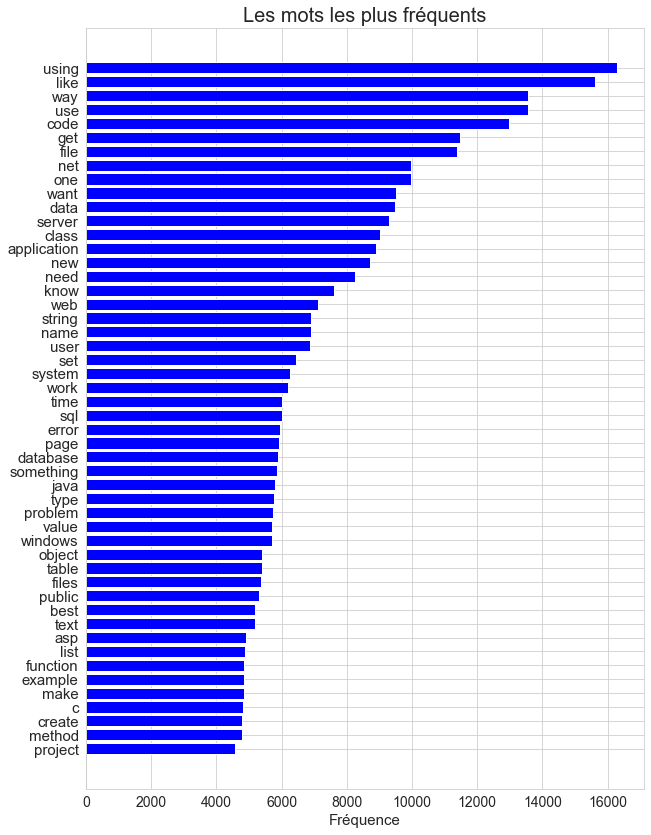

In [84]:
freq_features_50 = freq_features[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

#### Cible

In [88]:
print ("Creating the bag of words...\n")

y_train_bow = vectorizer.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_bow = y_train_bow.toarray()

Creating the bag of words...



In [89]:
y_train_bow.shape

(35000, 7879)

In [90]:
# Take a look at the words in the vocabulary
y_train_vocab_bow = vectorizer.get_feature_names()
print (y_train_vocab_bow)

['.emf', '.htaccess', '.htpasswd', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-framework-version', '.net-micro-framework', '.net-services', '.nettiers', '.refresh', '.sbr', '2d', '2d-games', '3-tier', '32-bit', '3270', '32bit-64bit', '3d', '3des', '3gp', '64-bit', '6502', '68000', '7-bit', '7zip', '8-bit', '8051', 'aaa-security-protocol', 'aac', 'aac+', 'abap', 'abbreviation', 'abbyy', 'abcpdf', 'abort', 'absolute-path', 'abstract', 'abstract-class', 'abstract-data-type', 'abstract-methods', 'abstract-syntax-tree', 'abstraction', 'abuse', 'accelerator', 'acceleratorkey', 'accelerometer', 'acceptance-testing', 'access-control', 'access-denied', 'access-levels', 'access-modifiers', 'access-specifier', 'access-vba', 'access-violation', 'accesscontrolservice', 'accessibility', 'accessor', 'accordion', 'accordionpane', 'account', 'accounting', 'accounts', 'accurev', 'acid', 'acl', 'acoustics

In [91]:
# Sum up the counts of each vocabulary word
y_train_dist_bow = np.sum(y_train_bow, axis=0)

In [92]:
# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(y_train_vocab_bow, y_train_dist_bow):
    print (count, tag)

2 .emf
32 .htaccess
2 .htpasswd
3532 .net
1 .net-1.0
16 .net-1.1
176 .net-2.0
9 .net-3.0
202 .net-3.5
4 .net-4.0
2 .net-assembly
4 .net-attributes
3 .net-client-profile
3 .net-framework-version
2 .net-micro-framework
1 .net-services
1 .nettiers
1 .refresh
1 .sbr
21 2d
1 2d-games
1 3-tier
15 32-bit
1 3270
2 32bit-64bit
43 3d
1 3des
1 3gp
94 64-bit
1 6502
2 68000
1 7-bit
4 7zip
1 8-bit
1 8051
1 aaa-security-protocol
4 aac
1 aac+
4 abap
1 abbreviation
1 abbyy
3 abcpdf
1 abort
2 absolute-path
4 abstract
16 abstract-class
1 abstract-data-type
1 abstract-methods
3 abstract-syntax-tree
7 abstraction
1 abuse
1 accelerator
1 acceleratorkey
3 accelerometer
3 acceptance-testing
7 access-control
3 access-denied
1 access-levels
3 access-modifiers
2 access-specifier
29 access-vba
2 access-violation
1 accesscontrolservice
19 accessibility
4 accessor
4 accordion
1 accordionpane
4 account
3 accounting
1 accounts
1 accurev
1 acid
6 acl
1 acoustics
6 acrobat
7 action
1 action-filter
3 actionlink
3 action

1 countries
1 country-codes
9 coupling
2 cout
7 covariance
1 covariant-return-types
1 cover
1 coverity-prevent
1 cp1252
14 cpan
1 cplex
4 cppunit
1 cpropertysheet
17 cpu
6 cpu-architecture
2 cpu-cycles
5 cpu-registers
1 cpu-speed
5 cpu-usage
1 cpython
3 cql
1 cqlinq
1 cqwp
3 cracking
30 crash
3 crash-dumps
2 crash-reports
3 crashrpt
7 crc
1 crc32
1 create-function
1 create-guid
1 createinstance
2 createobject
4 createprocess
8 credentials
5 credit-card
7 criteria
2 critical-section
6 crm
30 cron
5 crontab
2 crop
53 cross-browser
4 cross-compiling
1 cross-cutting-concerns
1 cross-database
8 cross-domain
1 cross-join
1 cross-language
80 cross-platform
1 cross-posting
1 cross-process
1 cross-product
1 cross-reference
3 cross-server
6 crossdomain.xml
2 crosstab
3 crowdsourcing
1 crt
3 crtp
9 crud
14 cruisecontrol
55 cruisecontrol.net
2 cruisecontrol.rb
1 crypt
5 cryptoapi
1 cryptographicexception
37 cryptography
71 crystal-reports
1 cs193p
5 cs3
5 csh
5 csla
2 csplitterwnd
3 csproj
1 cspro

1 git-pull
1 git-push
1 git-remote
1 git-rewrite-history
1 git-rm
2 git-stash
2 git-submodules
10 git-svn
4 github
2 gitignore
1 gitolite
1 gitosis
3 glade
11 glassfish
1 gldrawpixels
1 glew
5 glibc
2 glob
9 global
13 global-asax
1 global-state
8 global-variables
1 global.asa
1 globalevent
23 globalization
1 globus-toolkit
24 glossary
2 glsl
8 glut
1 glyph
21 gmail
1 gml
1 gml-geographic-markup-lan
1 gmt
8 gnome
9 gnu
1 gnu-classpath
4 gnu-make
4 gnu-screen
2 gnu-toolchain
5 gnupg
4 gnuplot
3 gnuradio
1 gnuwin32
1 gobject
1 god
2 godi
1 gold-parser
2 google-adwords
1 google-ajax-api
14 google-analytics
1 google-analytics-api
4 google-api
1 google-api-js-client
46 google-app-engine
1 google-apps
1 google-authentication
1 google-base
4 google-calendar-api
33 google-chrome
1 google-cloud-datastore
1 google-code
3 google-custom-search
1 google-data-api
1 google-desktop-search
2 google-docs
2 google-earth
1 google-earth-plugin
1 google-feed-api
3 google-gears
36 google-maps
1 google-maps-ap

1 multiprocessing
370 multithreading
2 multivalue-database
1 multiview
5 mutable
1 mutation-events
2 mutation-testing
15 mutex
1 mv
1 mvcc
1 mvcroutehandler
1 mvel
24 mvp
9 mvvm
2 mx-record
14 mxml
1 my-namespace
2 myeclipse
3 myfaces
6 myisam
3 mylyn
1 mysource
2 myspace
693 mysql
1 mysql++
1 mysql-connector
1 mysql-error-1025
1 mysql-error-1045
1 mysql-error-1052
1 mysql-error-1054
1 mysql-error-1062
1 mysql-error-1067
1 mysql-error-1071
1 mysql-error-1091
2 mysql-error-1093
1 mysql-error-1111
1 mysql-error-1142
1 mysql-error-1293
1 mysql-error-1451
1 mysql-error-2006
1 mysql-gui-tools
1 mysql-insert-id
7 mysql-management
1 mysql-parameter
1 mysql-select-db
1 mysql-workbench
1 mysql.sock
2 mysql4
4 mysqldump
8 mysqli
2 n-ary-tree
10 n-tier-architecture
1 n-triples
1 n2
1 n95
1 nagios
1 naivebayes
3 name-decoration
1 name-length
1 name-lookup
3 name-mangling
3 named-entity-recognition
3 named-parameters
10 named-pipes
1 named-query
4 named-scope
2 names
2 nameservers
1 namespace-organ

3 relationship
1 relative
11 relative-path
1 relaxng
17 release
1 release-builds
2 release-cycle
17 release-management
1 release-mode
2 relevance
5 reliability
2 reload
1 remobjects
1 remote-access
3 remote-administration
1 remote-branch
1 remote-client
1 remote-connection
7 remote-debugging
14 remote-desktop
1 remote-execution
2 remote-process
2 remote-server
1 remoteobject
42 remoting
1 removable-drive
12 rename
1 renaming
7 render
1 renderer
21 rendering
7 renderpartial
2 reorderlist
1 reorganize
1 repaint
1 repair
1 reparsepoint
3 repeat
17 repeater
19 replace
36 replication
49 report
1 report-designer
2 reportbuilder
46 reporting
148 reporting-services
1 reportingservices-2000
8 reportingservices-2005
1 reportlab
1 reportmanager
21 reportviewer
1 reportviewer2008
17 repository
1 repository-design
9 repository-pattern
2 repost
1 repr
2 representation
7 request
1 request-object
1 request-queueing
2 request.form
1 request.querystring
2 require
2 require-once
17 requirements
1 require

1 video-game-consoles
2 video-processing
3 video-streaming
2 viemu
9 view
1 view-source-chart
1 viewbox
2 viewdata
2 viewengine
4 viewer
1 viewexpiredexception
2 viewport
1 viewport3d
15 views
1 views2
39 viewstate
107 vim
3 vim-syntax-highlighting
2 vimdiff
2 vimeo
2 vimpulse
2 viper
13 virtual
1 virtual-attribute
3 virtual-destructor
3 virtual-directory
6 virtual-earth
9 virtual-functions
3 virtual-hosts
1 virtual-ip-address
15 virtual-machine
1 virtual-memory
1 virtual-path
13 virtual-pc
1 virtual-reality
3 virtual-serial-port
2 virtual-server
4 virtualbox
1 virtualenv
4 virtualhost
32 virtualization
1 virtualmode
1 virtualpathprovider
1 virtualquery
5 virus
1 virus-definitions
10 visibility
17 visio
1 vision
1 visited
4 visitor
3 visitor-pattern
1 visitor-statistic
1 visitors
11 vista64
2 vistadb
2 visual-assist
2 visual-build-professional
141 visual-c++
11 visual-c++-2005
3 visual-c++-2008
24 visual-c++-6
1 visual-editor
6 visual-foxpro
3 visual-inheritance
1 visual-programming
41

Nous allons afficher 50 mots les plus fréquents :

In [93]:
freq_target = DataFrame(zip(y_train_vocab_bow, y_train_dist_bow))
freq_target.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target['Pourcentage'] = round(freq_target['Frequence']*100/sum(freq_target['Frequence']),2)
freq_target[:50]

Word  Frequence  Pourcentage
758                   c#       4465         4.38
3                   .net       3532         3.46
3381                java       2598         2.55
349              asp.net       2224         2.18
763                  c++       1909         1.87
3405          javascript       1641         1.61
4956                 php       1350         1.32
6321          sql-server       1294         1.27
5304              python       1280         1.25
6307                 sql       1252         1.23
7560             windows        960         0.94
2959                html        854         0.84
1485            database        824         0.81
7359       visual-studio        820         0.80
757                    c        729         0.71
4313               mysql        693         0.68
7742                 xml        602         0.59
7594            winforms        574         0.56
5773                ruby        557         0.55
1370                 css        555         0.54
7247              vb.net        554         0.54
3499              jquery        548         0.54
3751               linux        527         0.52
356          asp.net-mvc        526         0.52
4909         performance        521         0.51
5776       ruby-on-rails        500         0.49
7659                 wpf        489         0.48
6588                 svn        482         0.47
7362  visual-studio-2008        465         0.46
5518               regex        440         0.43
7477        web-services        432         0.42
7119        unit-testing        430         0.42
3633   language-agnostic        410         0.40
4714              oracle        405         0.40
176            algorithm        395         0.39
5913            security        380         0.37
4291      multithreading        370         0.36
7204      user-interface        368         0.36
7276     version-control        352         0.34
3299              iphone        346         0.34
3743                linq        336         0.33
1601           debugging        334         0.33
165                 ajax        324         0.32
7551              winapi        324         0.32
6323     sql-server-2005        323         0.32
1980             eclipse        319         0.31
4639                 oop        317         0.31
3868               macos        313         0.31
6490              string        312         0.31
4915                perl        305         0.30

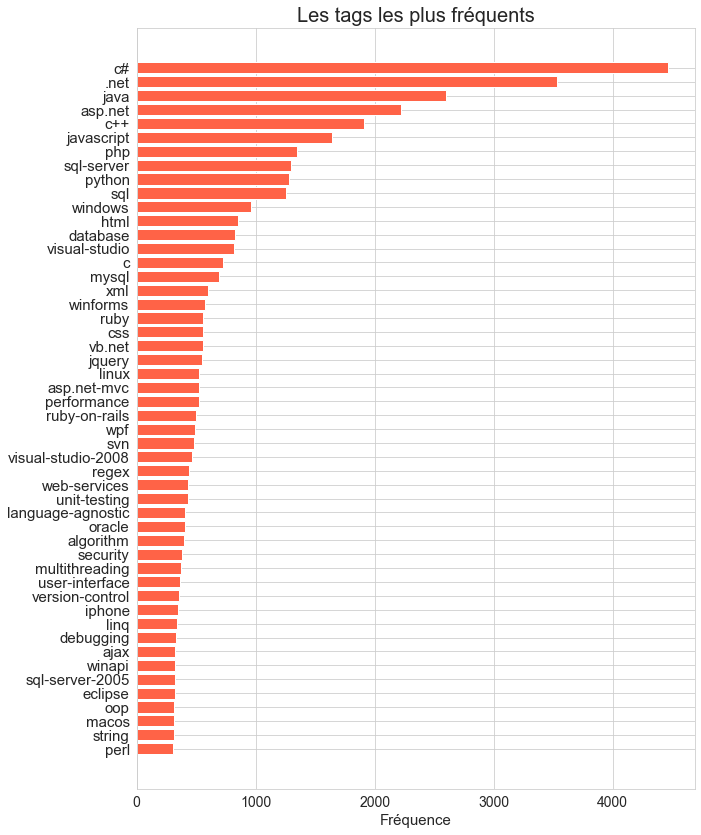

In [94]:
freq_target_50 = freq_target[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='tomato', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

#### Sauvegarder les données

In [97]:
np.save('Data/X_train_bow', X_train_bow)
np.save('Data/X_train_vocab_bow', X_train_vocab_bow)
np.save('Data/X_train_dist_bow', X_train_dist_bow)
np.save('Data/y_train_bow', y_train_bow)
np.save('Data/y_train_vocab_bow', y_train_vocab_bow)
np.save('Data/y_train_dist_bow', y_train_dist_bow)

In [96]:
#To download the data, execute, for exemple :
np.load('Data/y_train_bow.npy')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF - IDF

#### Feature

In [99]:
print ("Creating the TF - IDF...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tf_idf = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 50000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
X_train_tfidf = tf_idf.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_tfidf = X_train_tfidf.toarray()

Creating the TF - IDF...



In [100]:
X_train_tfidf.shape

(35000, 50000)

In [101]:
# Take a look at the words in the vocabulary
X_train_vocab_tfidf = tf_idf.get_feature_names()
print (X_train_vocab_tfidf)

['##', '###', '####', '#####################################################################', '##dispatcher', '#-#', '#-1', '#-bin', '#-class', '#-code', '#-create', '#-define', '#-end', '#-file', '#-files', '#-foo', '#-get', '#-id', '#-include', '#-line', '#-mybean', '#-name', '#-onclick', '#-self', '#-something', '#-usr', '#0', '#0-0', '#0-1', '#000', '#000000', '#000000-1px', '#1', '#2', '#3', '#333333', '#4', '#5', '#6', '#666666', '#8', '#990000', '#990000-face', '#basic', '#ccc', '#chooser', '#chooser-nav', '#content', '#define', '#defines', '#else', '#endif', '#endregion', '#error', '#event', '#event-values', '#f)', '#f)-((eq', '#f00', '#ff0000', '#ff0000-b', '#ff0000-font', '#fff', '#ffffff', '#if', '#ifdef', '#ifndef', '#import', '#include', '#include-boost', '#include-iostream', '#include-stdio', '#include-stdlib', '#include-string', '#include-vector', '#includes', '#main', '#nav', '#nav-ul', '#photo', '#photo-)', '#pragma', '#region', '#t', '#tmp', '#tooltip', '#tooltip-)',

In [102]:
# Sum up the counts of each vocabulary word
X_train_dist_tfidf = np.sum(X_train_tfidf, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(X_train_vocab_tfidf, X_train_dist_tfidf):
    print (count, tag)

3.9673283704547644 ##
0.9043003102115714 ###
0.7001771677572156 ####
0.1701352443875088 #####################################################################
0.3126129063276543 ##dispatcher
3.458650556916005 #-#
0.6893662447864398 #-1
2.881701841452784 #-bin
1.0792706886283392 #-class
1.3443635956222284 #-code
0.6434147024622768 #-create
1.29264635612567 #-define
0.7757922118232852 #-end
0.3060389627966753 #-file
0.5702109777629396 #-files
0.8682472261258116 #-foo
0.3845361925351717 #-get
0.9641889453906929 #-id
0.786523883313369 #-include
0.8833891186065539 #-line
0.4083687702711697 #-mybean
0.33442075966292684 #-name
1.9904017470201867 #-onclick
0.7280229847887142 #-self
1.9637472100065971 #-something
3.1249487631258557 #-usr
1.8629776934617592 #0
0.26555043044788895 #0-0
0.2220911720329093 #0-1
0.8635129352215231 #000
1.3557659797844115 #000000
0.45775964145786585 #000000-1px
8.947256295004747 #1
7.404574977489801 #2
3.17368373507885 #3
0.36416771579408647 #333333
1.6716037169032378

0.4057329471424151 (192
0.4057329471424151 (192-168
9.375973294307009 (2
4.762609498404646 (2)
1.2488644629354888 (2-0
1.2230650505160758 (2-0)
0.8775608315190426 (2-2)
0.9929762155391021 (20
1.0222909743017978 (200
1.5348041139512727 (2003
1.2375521202790767 (2003)
1.717557694262186 (2005
2.1701900276501664 (2005)
0.6405509862733572 (2007
0.9330332259277466 (2007)
1.6298285885527801 (2008
1.4273194577616353 (2008)
0.6888402241467433 (25
5.689216978049413 (3
1.750484710263977 (3)
1.5095964292171882 (3-5)
2.1299311367774876 (32
1.3570932823058042 (32-bit)
3.3151735618964633 (4
0.6302115580460337 (4)
3.7836700637470075 (5
1.2443608678680145 (5)
0.7759637207077279 (50)
0.5827547982087384 (50)-null
2.591800288444154 (6
0.7638290312997319 (6)
1.5070662477687526 (7
1.4820753507260203 (8
1.3326153087163712 (9
26.091617368423698 (a
4.488768998063917 (a)
0.2490460398487626 (a-'
2.0573742984861463 (a-b
2.151365482714461 (a-b)
0.3415138092610015 (a-ga
1.317830578717664 (a-k
2.2367521127860757 (a-

1.716979715772156 00'
0.52892975890296 00')
1.3382461863803112 00)
0.6934730738227874 00-0
13.986258690260271 00-00
0.7422641509600265 00-00'
0.2835587003681208 00-00')
1.6506663569723858 00-000
1.2829464149271932 00-01
0.5312899087666305 00-03
0.18471496198662737 00-0a
0.12791316105217243 00-0d
0.34726095590228123 00-1
0.32427726682790303 00-1691
0.36030807425322564 00-1693
0.3741289371858694 00-2
0.3948815553968389 00-20
0.4122845960904188 00-2006
0.351011492025173 00-30
0.428610971924001 00-31
0.3055075183308981 00-32
0.2320989414052517 00-34
0.2277685291058249 00-35
0.2771977186300401 00-36
0.11407158617425718 00-37
0.1699463581059823 00-38
0.37961649665737396 00-40
0.26721194270082327 00-6
0.19121022391811396 00-63
0.40282111434812484 00-65
0.7050334477165595 00-gmt
0.4045840621831331 00-n
0.503174354276422 00-p
0.6521594164923299 00-pm
0.22514127168956288 00-sec)
0.06654602606599888 00-td
0.3485744979773457 00-using
24.078317711226912 000
0.9997518519377533 000'
1.205394791504306

3.454607530032006 99%
1.052336450746986 99%-time
0.6630323930790876 99)
3.4450391481559537 999
1.061559085853058 999-999
0.9131472200183972 9999
2.370959387984364 9a
0.5610286877159054 9a-f
3.2521341021152055 9i
1.541001107275437 a'
1.3824018170064014 a's
5.104939640028844 a()
14.638120429024843 a)
2.066867158432952 a*
3.7740336013683033 a1
0.7691582704421809 a1-a2
2.77279351786193 a2
1.5144563274990457 a3
1.9737146769709577 a4
4.024993674928758 aa
3.385983855091946 aaa
0.637668065532752 aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
2.1733210262931415 aac
0.3619674775200059 aar
1.051686221059637 aasm
5.27296744805103 ab
1.3513595269397747 abandon
1.3107558985621102 abandoned
1.4759481138574826 abap
1.0759069386512408 abbreviated
1.8071104617532716 abbreviations
13.055103206907564 abc
1.5585906120816126 abc-com
2.1081973655050232 abcd
2.927342802079326 abilities
26.6092734086808 ability
1.8018885874871593 ability-create
164.94556285148337 able
7.32134680647467 able-access
1.1730433674402825 able-accom

0.9888312305181743 affid
1.454778722243381 affiliate
3.564034588165389 afford
1.7747365979751082 aforementioned
5.6115291937533005 afraid
0.8549509282534755 afs
1.074575385698852 afternoon
1.3706579694623295 afterward
5.152707339121576 afterwards
0.7821852165961329 ag
1.3528780192347605 again)
10.872014946043292 age
1.0441487897029513 age)
0.33286347037562186 age-)
1.8716013068137967 agency
1.753205642568595 agenda
0.5258730326154399 agenda-item
0.52712663073563 agenda1
12.315088259197038 agent
0.9109404226906644 agent-mozilla
1.909776269038838 agents
3.2338929796628904 ages
8.455196818322886 aggregate
0.9621768002344497 aggregate-data
0.9298831342057998 aggregated
1.8424288907272088 aggregates
1.5615611589909815 aggregation
13.014412595795934 agile
1.771316335618543 agile-development
8.759658688969482 agnostic
23.456399499022936 ago
1.8652957103256083 ago)
7.480295268169397 agree
1.4116360869997766 agreed
1.2227746975791192 agreement
0.1768116851738191 agroup
1.1333616226639598 ah
8.0

3.048279814527169 approach-problem
1.5478603408190141 approach-seems
1.4455069231721218 approach-take
1.1656421304716602 approach-thanks
0.753736166329999 approach-update
2.1362435922231686 approach-use
1.1296268007918568 approach-used
1.493999711694371 approach-using
0.9111964202909518 approach-work
1.374352378928519 approach-works
4.542028860465507 approach-would
1.2333095664536953 approached
15.822212208170239 approaches
3.6738371961825242 approaching
34.67458589671703 appropriate
0.9603951910124225 appropriate-data
0.9733881567288512 appropriate-location
0.8303375980359639 appropriate-place
0.698085440267808 appropriate-type
3.8248186356291205 appropriate-use
2.250189631587155 appropriate-way
4.168919183708197 appropriately
2.2857743570402067 approval
1.220634764502452 approve
3.611039701113929 approved
1.8326863567722211 approx
2.0192751341656328 approximate
4.382727908149038 approximately
2.1464680077425315 approximation
52.75869703922135 apps
0.18552600747293624 apps-enso
1.0705

113.60003285353356 b
1.4193784062784989 b's
2.079655661821932 b()
17.86316433741586 b)
0.6190914922468803 b)-(a
0.714545587533021 b)-return
3.5634673422866268 b-)
1.4832116696919506 b-*
1.4896830710681177 b-+
1.3961668828935616 b-0
1.6650292039963586 b-1
2.2767563986791184 b-2
5.548723586251658 b-b
0.508609192021409 b-br
16.094556229278094 b-c
1.9773932420142912 b-c)
1.141022325027163 b-class
1.0274533523073814 b-com
0.8840053281789964 b-end
0.3807834975870691 b-font
1.257433278068655 b-foo
1.0529815795112625 b-get
1.0095280148528583 b-h
0.029818427107183944 b-h2
0.7361573158768236 b-html
3.046397486780117 b-id
0.9966994604074174 b-int
2.7559813268325914 b-new
2.931773172462116 b-public
0.8855792218899998 b-return
0.7895915551398544 b-table
0.3747549825772496 b-td
1.6473565541621238 b-tree
0.8526205892499052 b-true
0.5318563646006201 b-type
0.4537625172326385 b-u
0.9419354033587459 b-using
1.654809958447794 b-want
1.0407770202226903 b-would
1.0776179559099268 b-x
0.7200860156741149 b03

1.0535364347172804 best-platform
1.5459982739442035 best-possible
30.19561684618457 best-practice
40.33637801381977 best-practices
1.173557824144213 best-practise
1.8322679419430477 best-regards
1.5142731580579105 best-resource
1.9879501752303836 best-resources
9.202865938599944 best-solution
3.4539133533149 best-strategy
2.4378392486505573 best-suited
2.5091532870549877 best-thing
1.1275821764960874 best-time
3.626131142513735 best-tool
2.118312693602174 best-tools
5.311560634996782 best-use
148.50351628788863 best-way
2.9861298407912367 best-ways
1.1865408982084211 best-would
3.461152441729253 bet
20.034478591950066 beta
0.7824179424843527 beta)
1.7751086240494183 beta-1
2.495115992306828 beta-2
1.0037538719857086 beta-release
1.7065805820623683 beta-testing
0.6073069299608878 betasection
0.26869836328697694 betreff
144.44908479948182 better
2.9181847505908767 better)
1.0632225967653253 better-)
2.305733983113703 better-alternative
1.2350692506376808 better-another
3.827407868738298 

0.8802627397069138 called-)
0.8052066438062562 called-c
0.8608332196468484 called-data
1.0367035612308289 called-even
1.1111538377850239 called-first
0.9518590798790072 called-foo
0.9836655564102857 called-form
1.686895201901893 called-function
0.8825069924568789 called-like
1.398277852641334 called-method
1.3233990512161216 called-twice
1.1080713080966678 called-user
0.833570578160722 called-using
0.926049643495499 called-via
0.8921537241668409 called-web
1.1316614389214288 called-within
9.082477214187998 caller
1.370479587053529 callers
0.3365682540939283 callhandlerexecutionstep
0.3365682540939283 callhandlerexecutionstep-system
1.1328538686967555 callid
56.617202110742625 calling
0.03886700100246954 calling-(methoddesc
1.0569136894724114 calling-c#
2.0963674883187404 calling-code
1.3120667706948914 calling-convention
0.9238417447238254 calling-external
4.292962790560024 calling-function
0.666209921306929 calling-get
3.4384937789813033 calling-method
1.2411033747400944 calling-metho

1.5353909823249106 collapsible
1.2490253192818634 collapsing
1.7584717849640232 collate
0.4905396557749233 collate-sql
4.365835393294583 collation
1.6670475081745382 collations
4.701338180293105 colleague
4.94518189577674 colleagues
7.930295255955952 collect
2.0077340499571146 collect()
0.22083864574744508 collect-(
1.1246830583877907 collect2
1.1246830583877907 collect2-ld
5.727187602905377 collected
0.2944515276632601 collectid
0.22083864574744508 collectid-url
3.4033401666191314 collecting
0.7661980872821947 collecting-data
66.89200284851171 collection
2.116055569753858 collection)
1.5340157750966599 collection-c#
1.0840545961077988 collection-class
1.2210917778163473 collection-data
1.221119807863797 collection-libraries
4.728653226408883 collection-objects
1.1567421110027827 collection-type
0.9492297401958432 collection-using
0.9249006567926037 collection-would
1.4465902456032445 collectionbase
23.548600696039298 collections
4.960542363949309 collections-generic
0.4312689377934999

1.0468473453725888 creation-time
3.072343892648813 creative
3.528118872304257 creator
2.3732336505478693 credential
0.776456018488302 credentialcache
15.194195669132158 credentials
1.284059853576564 credentials)
0.8885872427891062 credentials-new
9.766861915721561 credit
0.6419312366288921 credit-acc
5.2989360002810955 credit-card
1.4545863705569255 credit-cards
0.11343364575384096 credit-used
1.789777432042098 creditcard
1.4836916742866917 credits
1.5055451122242947 creep
1.2837841505618428 cref
18.16435705883753 criteria
0.9085705328138292 criteria)
1.3524293118464414 criteria-query
1.2211709240174131 criterion
11.209885055811489 critical
0.6430077924057667 criticism
2.4655493947868967 crlf
0.5390506102118263 crlf-+
6.695841103435775 crm
1.581553345741593 crm-4
0.3075484110638018 crm-webservices
11.024116266240307 cron
3.6544765196187528 cron-job
1.9140059423791713 cron-jobs
3.402889542193722 crontab
2.777362968914219 crop
1.4816136002603644 cropping
42.95891307471331 cross
7.7788321

1.4658055425573304 data-across
1.0662409294772497 data-actually
0.6976786689132527 data-already
1.2430280988673048 data-also
2.008111165031416 data-another
1.4754456958541258 data-anyone
1.004664859564421 data-app
2.3738906893864145 data-application
0.5605949960223683 data-around
1.7820916927646087 data-array
1.2653419775772643 data-asp
2.542312749555977 data-available
3.475719088999639 data-back
1.2675812985221864 data-based
0.7917073945380069 data-best
1.2913674798052148 data-bind
7.000966451200433 data-binding
2.989476722049174 data-bound
1.2170299371219329 data-c
1.239241071153137 data-c#
1.2070994577002592 data-can't
1.1047067448715142 data-central
1.4027974621956658 data-change
0.6802835046401781 data-changed
1.5184284009182827 data-changes
0.8619778782916703 data-class
0.9426550655411313 data-classes
1.2349224094986733 data-client
1.0877387670481986 data-code
1.0238355364306129 data-collection
1.6870800271261122 data-column
1.2715309635976753 data-columns
1.9105751956634167 data

1.0548571904771196 displayed-text
1.942794237167934 displayed-user
0.9940309206950728 displayed-using
1.1153257891440564 displayindex
0.3034847866781632 displayindex)
0.3034847866781632 displayindex)-value
25.976748546497348 displaying
1.3517842252343137 displaying-images
1.218294490712304 displaying-information
1.2717365203232958 displaymember
1.824213903483295 displaymemberbinding
1.6769385995892747 displaymemberbinding-binding
0.7290515162482856 displaymemberpath
1.7336758873709366 displayname
0.799218219051983 displayobject
24.531389883170675 displays
0.9685144746344231 displays-correctly
1.412941844865598 displays-data
1.0986837133862388 displays-list
0.5993995100832634 displaytext
1.1374923431241506 disposable
1.5519653997715148 disposal
10.947946538859693 dispose
7.372397174720604 dispose()
2.0189374570234886 dispose-method
4.154011678795924 disposed
1.9386904540495649 disposing
3.127327767333337 disposition
2.136245711460933 disposition-attachment
1.989867089067193 dist
10.1128

0.9835853850186148 events-net
0.5626670304795145 events-originate
1.0188969257497429 events-raised
0.9080921052616355 events-triggered
1.0351733578923346 events-using
1.0634562308427404 events-would
1.1614205115010279 eventtarget
0.6545250538042154 eventtype
0.7981843799577111 eventual
15.132811325798993 eventually
41.374170172337394 ever
1.4937207447806518 ever-done
1.6598725275862163 ever-encountered
1.1662052436469657 ever-found
1.4890703846107407 ever-get
1.637913359581704 ever-need
1.739547672829892 ever-seen
1.8160391884510911 ever-since
1.8885543297198135 ever-tried
3.102513069863417 ever-use
3.8938941570580843 ever-used
1.1204287317673984 ever-want
0.9510030057976668 evernote
106.17748805949566 every
1.6458117577100988 every-10
0.7334913798776033 every-15
1.2695660209091408 every-2
2.6021706487928946 every-5
1.0535239651258532 every-browser
1.2534698116525915 every-build
1.199534721208299 every-call
0.976948305582096 every-change
0.8016794649601776 every-character
2.02134393387

11.219841627756237 fired
62.44211474076844 firefox
0.8453921326616909 firefox's
2.652838899912233 firefox)
3.2025340296068787 firefox-2
9.452586180500333 firefox-3
1.9894913726482553 firefox-chrome
3.6060486484095486 firefox-extension
4.497314448523722 firefox-ie
1.122737296583864 firefox-internet
1.9984144999223739 firefox-opera
2.1331923120422145 firefox-plugin
4.40126795617842 firefox-safari
9.197513688995599 fires
12.172130773312881 firewall
0.3727912010605944 firewall-1
2.279817538083029 firewalls
7.382290942075082 firing
2.6177298136861005 firm
0.8055499900394683 firms
1.6976600877670305 firmware
148.9514183384735 first
1.5642335673358023 first()
2.0713387391639357 first)
0.9005140308808832 first-)
1.1196305038380276 first-2
1.1698235239579715 first-5
1.173651987010171 first-answer
1.2812958112511625 first-application
1.981489696271023 first-approach
2.3814508799082623 first-argument
1.8716355193797973 first-attempt
1.527375229412968 first-call
1.1619353455632186 first-case
2.336

1.7595881211462838 github-com
74.74428192307995 give
1.9314444448461865 give-access
1.6418335397717367 give-advice
1.3231267271216913 give-answer
1.3653433991804484 give-better
0.7465546565924095 give-control
1.5917341728286272 give-error
3.8239355892741873 give-example
1.5324216204552028 give-examples
4.089200341607713 give-good
1.2318647582727478 give-hint
1.253378208730962 give-idea
1.6727658558229395 give-information
1.0142418425528512 give-list
1.231247876017436 give-name
0.8697445293021304 give-new
1.242875954725504 give-one
1.9595444641678572 give-pointers
1.137896594510554 give-short
0.990173195676314 give-simple
0.7339278421317554 give-try
1.532744048152154 give-us
3.5216257976430025 give-user
1.708388955032876 give-users
95.46248496742695 given
1.1572848505312268 given-2
0.975303573881052 given-array
2.165955787757346 given-class
1.1198618387471282 given-code
1.398752991308357 given-database
3.3706462950495495 given-date
1.4342886313036953 given-directory
0.9454395250489559 g

1.0064776124834058 i'm-100%
6.092807984930776 i'm-able
0.9030234407511584 i'm-accepting
1.0656979679180356 i'm-accessing
3.1641945977488297 i'm-actually
3.391706171576661 i'm-adding
3.378454963857603 i'm-afraid
0.9572849955227483 i'm-aiming
1.5709890724907813 i'm-allowed
1.0594823538999851 i'm-almost
3.5205481210411333 i'm-already
9.152832451667102 i'm-also
1.6139934449572066 i'm-always
11.528627811914442 i'm-asking
7.6224589915776795 i'm-assuming
4.994982817571714 i'm-attempting
11.903130735517617 i'm-aware
2.104148636298377 i'm-basically
1.5090120723106701 i'm-beginner
1.7683571789117434 i'm-beginning
1.5232546147071002 i'm-big
0.8287600867299811 i'm-binding
4.964651652735861 i'm-bit
13.15003685377254 i'm-building
1.4939006762135076 i'm-c#
4.179593349461547 i'm-calling
1.336810010198476 i'm-certain
0.9510518693264665 i'm-changing
1.2659793531448722 i'm-checking
2.3368898430636706 i'm-clear
2.006920431033486 i'm-coding
1.40604058096804 i'm-comfortable
1.760261413160332 i'm-coming
1.94

1.4473211414194882 int-3
0.7962239132567261 int-4
1.6724586650304107 int-array
2.429760114268922 int-b
0.7084067807343947 int-b)
0.996603783249107 int-bool
1.1175206821105081 int-c
0.5731623880244926 int-class
1.2033719711123405 int-column
1.5015094782514613 int-count
0.855651469175895 int-data
0.6787725693866213 int-declare
0.4138120042211947 int-dm
1.3703261178405355 int-double
1.1698560211780364 int-field
1.016749877188784 int-foo
0.7968881338719278 int-foo()
1.3272997417376577 int-get
0.6803321217505942 int-i'm
4.012554619500113 int-id
1.0865486166762746 int-identity
0.7966661366785254 int-identity(1
1.5332211801493587 int-index
0.6999541444847827 int-index)
3.78208712034094 int-int
0.674424963522219 int-iterator
1.3831671785615274 int-j
0.5914511285397874 int-len
0.721709112542858 int-length
1.1131457199326549 int-list
0.7164100719477935 int-long
0.681259668087039 int-main
6.38333317259428 int-main()
2.855121840176515 int-main(int
0.8922431312171746 int-main(void)
0.54044117944379

0.9468288706580157 know-order
1.0939762772218113 know-others
3.051538890747211 know-people
2.006146397722379 know-php
14.313518121905584 know-possible
1.3975885068023237 know-pretty
2.2474713942465923 know-probably
2.3315942699795196 know-problem
1.4758428612102004 know-put
1.8096974657355793 know-question
1.5677443389761714 know-read
1.3992057240359728 know-real
2.364226979113875 know-really
2.486803385696747 know-reason
0.8347341829528571 know-resolve
1.6960597756819868 know-right
1.9507569932224593 know-run
1.638072793138083 know-script
1.2851187696601274 know-see
5.13729497367942 know-set
1.8842684558788974 know-several
1.4678325059635733 know-similar
3.4380064930767604 know-simple
1.9120442904820016 know-size
2.0298334172517962 know-solution
2.8981623401022287 know-solve
1.7634513608864357 know-someone
4.981742801462075 know-something
1.4176913291497362 know-sort
1.8247742964915261 know-sql
1.5201451965350468 know-standard
2.7368580307372072 know-start
1.244188000695072 know-still

1.3038452300373098 looking-alternatives
1.8678922895898498 looking-answer
1.0172900873669397 looking-answers
1.2515325188588837 looking-anything
3.6527671652925306 looking-around
4.776069481321638 looking-best
1.7861957947439042 looking-better
1.6907584233684005 looking-build
1.3324296647942422 looking-c#
4.509557447806073 looking-code
1.9643488320990021 looking-create
1.1655377044111792 looking-cross
1.0814373236218275 looking-database
1.1958419522803392 looking-different
1.9073357491570846 looking-easy
1.4090526871082856 looking-either
1.147740506033295 looking-elegant
1.4757023564650018 looking-equivalent
3.8538693276791207 looking-example
1.2212694927639682 looking-examples
1.1991389392666019 looking-file
2.8312137570319162 looking-forward
1.909287603985793 looking-free
2.1709432976821414 looking-general
1.4395566441994934 looking-generic
2.1116845690489785 looking-get
9.914406928722729 looking-good
1.1047986348479144 looking-guidance
1.0770122650203973 looking-help
1.4103916368875

2.367023710892746 mp3-file
3.21285998967381 mp3-files
2.1494926147129445 mp3s
1.2626917650149811 mp4
2.2841174022487136 mpeg
0.5204793912326675 mpfr
2.88865847410759 mq
2.0804012669208727 mr
73.75833307871765 ms
1.077999693459435 ms's
0.7613918354800908 ms**
22.023028559082114 ms-access
1.3956093751806702 ms-crm
0.9287676229825474 ms-dos
3.7517102282227084 ms-excel
0.4287924501610857 ms-internal
0.834240850121723 ms-new
3.3363046770497617 ms-office
1.3061288189216715 ms-outlook
2.1129940509139318 ms-project
24.866923238690926 ms-sql
1.8813790398910208 ms-test
3.6203918510789457 ms-visual
4.579720037231375 ms-word
1.5913969993231099 msaccess
22.143256734504185 msbuild
0.8865923974820175 msbuild-project
2.0138205724585982 msbuild-task
1.4019110269946105 msbuild-tasks
1.10465987883965 msc
2.9902339305022263 mscorlib
0.06932383727577081 mscorlib-0fce8176e7f03af02b5696345589d82b
1.236356590277161 mscorlib-dll
0.06932383727577081 mscorlib-ni
1.0545785031049608 mscorlib-version
0.697773920831

1.5843411784734545 new-build
1.3209711311375558 new-button()
3.9042761395032577 new-byte
2.669437671675373 new-c#
1.5924423704260304 new-c++
2.3691259083169287 new-char
0.6068717742889118 new-child
5.333081660104023 new-class
1.1716418746031316 new-client
5.19269529346868 new-code
2.7253687520709673 new-column
0.8820654583739311 new-columns
2.0380544616544802 new-connection
1.7167539636363165 new-content
3.9020299175331288 new-controller
1.1282492884206603 new-css
0.8997170078250724 new-customer
6.359306321229017 new-data
4.166534830220911 new-database
1.1945285856148151 new-dataset()
0.6372558039817443 new-datatable()
1.319402748434905 new-date
1.4182350672518316 new-date()
1.241266901547604 new-db
0.9488040912081668 new-delete
1.296785257312522 new-developer
1.6009497113214428 new-development
2.780621496034839 new-dictionary
0.7797577934238116 new-div
1.1507743891018523 new-document
1.1143075722062628 new-domain
0.9293414011812406 new-domdocument()
1.4082379393753057 new-dynamic
1.47

2.2936553902464576 onerror
33.603291669420756 ones
2.059054813871764 ones)
1.1451172021396518 ones-i've
1.0784557266898052 ones-know
1.2166716271522076 ones-like
1.18444803440874 oneway
1.1502638870434432 onfailure
1.3574597673885955 onfocus
2.685557497214926 ongoing
0.8372973688869749 oninit
0.47342050333783803 onitemdatabound
0.8269582913444742 onkeydown
2.0069089390900894 onkeypress
0.748880133949549 onkeyup
36.767955098399 online
0.9746685238717374 online-documentation
1.435600967446535 online-help
1.9568633539476707 online-resource
3.042944355091747 online-resources
1.3235542388117947 online-source
0.8194435056380476 online-tutorials
5.871192186171358 onload
0.9329440873987037 onload()
0.3272274903195717 onload(eventargs
0.3272274903195717 onload(eventargs-e)
1.4294527268653403 onload-event
0.6309683726629756 onload-function()
4.100911452206831 only)
1.3027294865696633 onmousedown
0.6247277830046525 onmousemove
1.0965311355670695 onmouseout
3.0933133422399033 onmouseover
1.4991082

1.1818416409226222 pocketpc
2.4243304547414564 poco
0.9505391829499202 pocodeoutput
1.6316520374731993 pod
3.701233911071751 podcast
1.966931505195015 podcasts
2.063002488187103 poi
106.22527544323975 point
2.5657679958584563 point)
0.5058724283963071 point-)
0.9889017616791831 point-anything
0.6725811607998411 point-application
0.9057630989277918 point-browser
1.1143662581997487 point-code
1.035811163472677 point-data
0.9620158382942232 point-different
2.10066225436992 point-direction
0.7149316865112084 point-error
1.6288940995948384 point-example
0.42101552556316113 point-exception
0.9859613032103066 point-failure
3.6533091984735373 point-good
1.2168115329285747 point-i'd
2.666428759852704 point-i'm
0.674331389752333 point-know
2.26737994648608 point-need
1.1442938084919891 point-new
2.0890361016747634 point-number
1.9572179082332768 point-numbers
1.3323356666031378 point-one
0.6909357603154095 point-point
1.1329301919154455 point-question
11.26694436513545 point-right
0.669791787506

1.151088835330134 programmers-use
89.36954846750858 programming
2.092320078744399 programming)
1.8683622373887783 programming-c
1.8048561585012521 programming-c++
1.7597404896572733 programming-environment
1.2421286362516313 programming-experience
1.3809354254261115 programming-java
12.924218929631486 programming-language
6.6575143106828865 programming-languages
1.352764394524053 programming-model
3.3873514339327304 programming-question
1.5447207642998142 programming-related
1.4804236829727522 programming-windows
37.628296701011216 programs
1.1697528331140952 programs)
1.1244682825775874 programs-i'm
21.222505045136295 progress
7.054806970102791 progress-bar
0.8248500543941621 progress-indicator
2.382419465655572 progressbar
0.6899970205853856 progressindicator
1.5495176552042207 progressive
1.1614738164686844 progressive-enhancement
0.849230977990669 progressively
2.8777009077080726 proj
1.4982310774448442 proj-file
0.6471088588255515 proj1
229.83681419897997 project
6.502947837468775

2.352593731364606 reference-type
1.8971078915732549 reference-types
1.0657472454081487 reference-web
1.3874260572984702 reference-would
19.170797758644547 referenced
1.5236308709083906 referenced-assemblies
1.1149862369293186 referenced-assembly
0.8053432113188139 referenced-function
0.643051243064624 referenced-object
0.6423210519196343 referenced-project
0.48086559281514835 referencedassemblies
42.78037984578632 references
0.9427504161253004 references-object
1.0332046571381839 references-projects
1.1205057340616982 references-would
10.417151871967649 referencing
1.4697177934161645 referential
0.8955070496304077 referential-integrity
2.187947936580204 referer
1.8020782414954764 refering
3.596914252184903 referred
1.616319496501295 referrer
7.970145025508973 referring
4.109175983530281 refers
0.7711453004618449 refid
1.1911691121460146 refine
8.296661950963747 reflect
0.5416410707532758 reflect-method
0.5641756059278752 reflect-nativemethodaccessorimpl
4.007871597017316 reflected
1.41

1.010583275104672 rng
5.0808366309216915 road
1.3988600959416537 roadmap
1.780797974122656 roaming
3.7138038230796706 rob
1.9232430256814246 robert
1.7792416492020058 robocopy
4.027467419125634 robot
1.1612570178380048 robots
10.714896297822127 robust
1.646230372061222 robust-way
2.140688023820475 robustness
1.2063322527677225 rock
1.5690515277923744 rocks
0.8297639671378905 rolap
15.135813104837938 role
1.3835528780602349 role-based
0.09834120169306483 role-level
0.670337993849188 role-name
0.6715032008038181 role-string
12.019808663316136 roles
0.09834120169306483 roles-r
14.045337435984093 roll
3.1056052694650975 roll-back
0.08850708152375834 roll-tbl
8.688137562824746 rollback
1.2986781875336075 rollback()
1.147891811916822 rollback-transaction
4.5951912550493 rolled
1.8380350373992103 rolled-back
6.872922024804551 rolling
1.0456754443326945 rolling-back
0.642900515848906 rollingfileappender
0.7865433877176746 rollout
2.827217315448217 rollover
0.7844327637658637 rolls
1.1153505420

0.6619697319545286 services-however
0.8139444644118453 services-need
0.826542500249401 services-project
1.795045127662295 services-protocols
2.870786254187406 services-report
1.8546176449802163 services-running
0.8198976902629667 services-service
0.7843695319909443 services-soap
1.0256675152394648 services-use
1.369325548990585 services-using
1.1735865344595222 services-want
0.9811297771455127 services-windows
1.933958001999611 services-would
0.25942993376115964 servicesoap
5.548117818231691 serving
22.97611582386 servlet
0.3498193073273652 servlet-class
1.5849343513374115 servlet-container
1.2395807060617503 servlet-context
0.6579186897321445 servlet-engine
0.4030078154655111 servlet-http
0.45784736244741947 servlet-internal
1.2027407620780852 servlet-jsp
0.7736008299714293 servlet-mapping
1.1550149389952904 servlet-name
0.6652729368919017 servlet-servlet
0.9240067246044261 servletexception
5.507429994976285 servlets
0.5334164682244176 sess
80.7616109441987 session
0.7593484700492846 

3.1429380594157363 sound-like
1.278572337124565 soundex
18.12563092089364 sounds
6.409172854731718 sounds-like
2.506721801361551 soup
167.79522644645579 source
8.725545938900362 source)
1.9071571389179933 source)-java
0.58062927876221 source)-javax
0.40489548010295306 source)-sun
1.0117931721939826 source-)
2.1321153469335385 source-alternative
1.4382379600793564 source-application
1.1523328074317079 source-asp
0.5486978990715808 source-aspx
0.6030854859159779 source-binding
1.0939953139254872 source-c
37.10247981583413 source-code
1.2345968547132349 source-code)
1.6526927234341342 source-commercial
30.469929709555693 source-control
2.1014219158194725 source-data
1.3013913940088664 source-database
0.6058124155659445 source-destination
1.448436375652176 source-directory
1.2467840528658827 source-error
0.07521952958377127 source-fe
9.529925341353136 source-file
9.122513713600016 source-files
1.3928866051356181 source-folder
2.470171751365769 source-free
0.06932383727577081 source-hash
1.

1.5239944841370003 system-timers
0.8466947532032454 system-transactions
4.06168263592278 system-tray
1.9614340651173168 system-type
2.04113506404736 system-use
2.2147239035842032 system-used
1.7509233561139481 system-user
0.8875468848205663 system-users
1.762039531233025 system-uses
5.135029178007648 system-using
0.7886648615759102 system-version
2.279611354856571 system-want
1.0736795836059352 system-way
23.159020318146815 system-web
2.145969767748432 system-wide
17.332070380186952 system-windows
1.0857159481382106 system-without
1.0804712585662104 system-work
1.3571607015271863 system-works
5.574330199291489 system-would
1.0042564930991007 system-written
6.812949829517783 system-xml
3.8462416486036615 system32
0.5464148976365721 system32-drivers
0.6704324247453767 systemexit
0.5502553464480414 systemhooks
0.921670775375704 systemmanager
38.92297525773004 systems
1.3861082368401927 systems)
1.050532076986626 systems-i'm
1.81062542528821 systemtime
1.049716725774542 systime
1.268958967

9.151834129608877 toggle
0.7613809562482985 togglebutton
1.0765164576176813 toggling
14.765515308111087 token
0.028090673104906143 token-usr
2.325341726425816 tokenize
6.03856108311106 tokens
17.19019785159898 told
1.2598467367351869 tolerant
1.9571659832362245 tolist
3.2548087782903408 tolist()
1.1189516161123239 tolower
2.0004252095849697 tolower()
3.3474840801061037 tom
1.2331434353669868 tomahawk
29.39189788870282 tomcat
1.2854923352230507 tomcat's
4.7962060573902 tomcat-5
3.334650259374046 tomcat-6
1.16776056085668 tomcat-instance
1.7106297192308983 tomcat-server
0.7395907927523164 tomcat-util
1.047374973411622 tomcat5
3.514109492556142 tomorrow
4.74892275880962 ton
1.7958676976206986 tonight
5.346806003307941 tons
0.3682291882799797 tonumber
4.308097790754758 too)
11.848198163426453 took
1.3025040158279246 took-look
106.2938345475478 tool
3.42892694341312 tool)
1.5399335580702458 tool-allows
1.5537596695229474 tool-also
1.4323725209249958 tool-automatically
1.9682105913466899 too

16.089426217683965 use-one
2.2622105036592237 use-open
1.422257916111041 use-operator
1.128454315214032 use-option
1.8082794983482517 use-oracle
1.747323135767814 use-order
0.8171480551522722 use-original
1.4244190181657033 use-os
0.9776108360185403 use-output
1.4272954447403248 use-page
0.9494229701028858 use-parameter
1.5061287477214271 use-particular
0.9430406052508815 use-path
1.612804700266715 use-pattern
1.592373798736361 use-perl
6.241703290210746 use-php
1.4467422976141875 use-plain
2.1603510472791747 use-pointers
1.3531068930143266 use-port
1.820462955660151 use-post
1.137144219257336 use-pre
1.5106241315713216 use-private
1.499360776871296 use-process
1.2090635126855005 use-production
1.4581974655845065 use-profiler
2.623248669949149 use-program
1.219038506476437 use-project
1.2512400337660012 use-properties
1.551831991075955 use-property
1.4143045344443403 use-proxy
1.3786293652845787 use-public
4.748068990569715 use-python
1.8429457175269222 use-query
1.882672678378797 use-

1.583640800808408 version-project
1.6071373471651447 version-question
1.0157676074690971 version-rails
1.5521801865767098 version-site
1.202041715603687 version-software
2.45703616554499 version-sql
0.5635104595322106 version-svn
1.2252852156638518 version-use
1.5845993741895081 version-using
0.9438484254976769 version-version
2.1188484636068003 version-visual
1.1222188992508177 version-want
0.9327888174942238 version-web
2.776696127406864 version-windows
1.7599914270141173 version-would
0.5112930393902713 versionb
3.4656587768069573 versioned
10.17211432670343 versioning
40.60281189198986 versions
1.0960644486678928 versions)
1.1026779473089072 versions-1
1.2117545946593125 versions-net
0.08061223592047988 versions-quartzcore
2.2169333847018864 versions-visual
2.6500248833288316 versions-windows
13.11404283615837 versus
3.7095849567413786 vertex
13.490085433010359 vertical
1.0264711624135763 vertical-align
1.631064190577948 vertical-horizontal
2.6475986831670166 vertical-scroll
1.1265

3.1013703221723254 winform-app
2.5839441511373153 winform-application
40.353008285199934 winforms
1.1495690350339554 winforms)
5.837221698675723 winforms-app
8.356487175216218 winforms-application
1.3977137402089441 winforms-applications
1.6327809541016673 winforms-c#
2.3507242424535515 winforms-control
1.398448247065535 winforms-net
1.5380514291297425 winforms-wpf
4.288652860107597 winfx
4.207596291152545 winfx-2006
0.9343777768022745 winhelp
0.9456462905473649 wininet
1.0073569990132725 winmerge
1.2168595313391126 winner
0.8192167800996925 winning
1.4168138741217438 winnt
0.06932383727577081 winnt-processor
1.9527150660157633 wins
2.195068289815283 winsock
0.5279522840411692 winsxs
1.1563792560919304 winter
5.222884324896847 winxp
1.619724731879183 wipe
1.115039034622287 wiped
0.029818427107183944 wir
7.423334453368125 wire
1.8336841389343599 wired
5.932211595541309 wireless
2.006041549337456 wireshark
2.1086816709379814 wiring
1.898823401007874 wisdom
8.120515772795956 wise
1.145893

Nous allons afficher 50 mots les plus fréquents :

In [103]:
freq_features = DataFrame(zip(X_train_vocab_tfidf, X_train_dist_tfidf))
freq_features.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features['Pourcentage'] = round(freq_features['Frequence']*100/sum(freq_features['Frequence']),2)
freq_features[:50]

Word   Frequence  Pourcentage
45787        using  504.928320         0.24
25217         like  485.828480         0.23
47482          way  483.617766         0.23
45036          use  472.026262         0.22
17340         file  456.798371         0.21
29005          net  445.859626         0.21
9888          code  439.060767         0.21
19331          get  390.894063         0.18
37920       server  385.667582         0.18
5639   application  373.157419         0.17
47173         want  364.158603         0.17
12504         data  360.382658         0.17
30447          one  355.798024         0.17
9364         class  338.791289         0.16
28779         need  330.518972         0.15
47904          web  322.640747         0.15
24448         know  321.689865         0.15
40070          sql  309.075987         0.14
29241          new  302.928637         0.14
40795       string  294.266442         0.14
45481         user  292.917457         0.14
12779     database  289.440420         0.14
48402      windows  283.532364         0.13
23763         java  281.410422         0.13
31434         page  276.277672         0.13
7198          best  275.940215         0.13
17669        files  268.904564         0.13
6273           asp  258.369436         0.12
43264         time  255.638434         0.12
39634    something  253.341979         0.12
38328          set  253.066630         0.12
8147            c#  251.653879         0.12
48729         work  249.812034         0.12
28516         name  248.107363         0.12
41801        table  243.169229         0.11
30026       object  240.325059         0.11
25769         list  237.220439         0.11
18942     function  236.793563         0.11
15854        error  235.398752         0.11
46347        value  233.204479         0.11
42581         text  232.819523         0.11
17854         find  232.049286         0.11
41636       system  231.406948         0.11
33790      project  229.836814         0.11
11850       create  226.795428         0.11
27400       method  222.940527         0.10
44299         type  222.171002         0.10
11296      control  221.211722         0.10
20006         good  218.498577         0.10
26638         make  216.578408         0.10

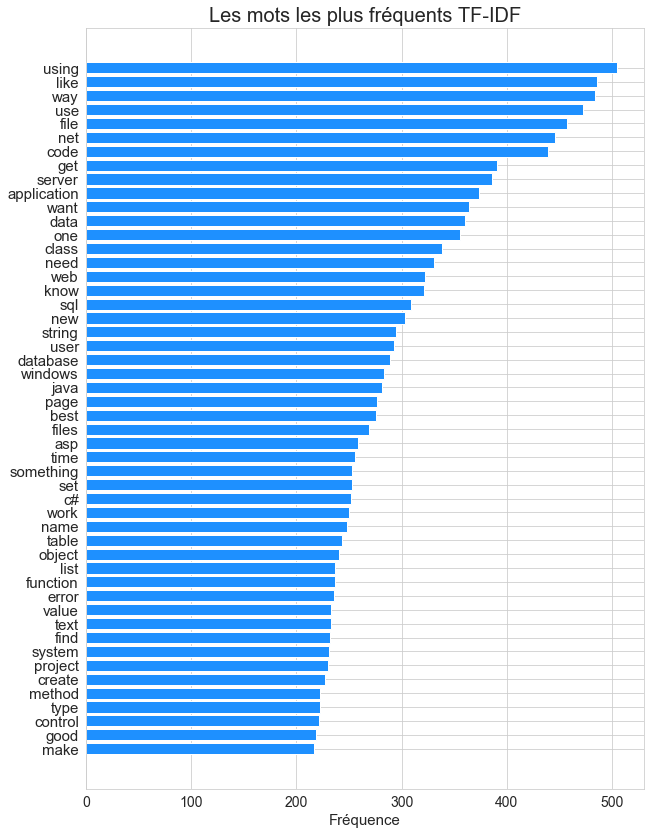

In [104]:
freq_features_50 = freq_features[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='dodgerblue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

#### Cible

In [105]:
print ("Creating the TF - IDF...\n")

y_train_tfidf = tf_idf.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_tfidf = y_train_tfidf.toarray()

Creating the TF - IDF...



In [106]:
y_train_tfidf.shape

(35000, 7879)

In [107]:
# Take a look at the words in the vocabulary
y_train_vocab_tfidf = tf_idf.get_feature_names()
print (y_train_vocab_tfidf)

['.emf', '.htaccess', '.htpasswd', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-framework-version', '.net-micro-framework', '.net-services', '.nettiers', '.refresh', '.sbr', '2d', '2d-games', '3-tier', '32-bit', '3270', '32bit-64bit', '3d', '3des', '3gp', '64-bit', '6502', '68000', '7-bit', '7zip', '8-bit', '8051', 'aaa-security-protocol', 'aac', 'aac+', 'abap', 'abbreviation', 'abbyy', 'abcpdf', 'abort', 'absolute-path', 'abstract', 'abstract-class', 'abstract-data-type', 'abstract-methods', 'abstract-syntax-tree', 'abstraction', 'abuse', 'accelerator', 'acceleratorkey', 'accelerometer', 'acceptance-testing', 'access-control', 'access-denied', 'access-levels', 'access-modifiers', 'access-specifier', 'access-vba', 'access-violation', 'accesscontrolservice', 'accessibility', 'accessor', 'accordion', 'accordionpane', 'account', 'accounting', 'accounts', 'accurev', 'acid', 'acl', 'acoustics

In [108]:
# Sum up the counts of each vocabulary word
y_train_dist_tfidf = np.sum(y_train_tfidf, axis=0)

In [109]:
# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(y_train_vocab_tfidf, y_train_dist_tfidf):
    print (count, tag)

1.2913708286761647 .emf
20.315782399608562 .htaccess
1.779107648085159 .htpasswd
1234.6974528795652 .net
0.7619725969000765 .net-1.0
10.392397318668808 .net-1.1
100.03215112054504 .net-2.0
5.747630599165471 .net-3.0
116.19317476212467 .net-3.5
2.8020163600581363 .net-4.0
1.4021474579413487 .net-assembly
2.878015832314196 .net-attributes
2.507615674379909 .net-client-profile
2.232351585205234 .net-framework-version
1.1276009973949317 .net-micro-framework
0.5 .net-services
0.7746644334350541 .nettiers
0.5939616369871367 .refresh
0.688924552628461 .sbr
11.502177251094954 2d
0.5024292798328295 2d-games
0.8753148285374648 3-tier
8.959456341091435 32-bit
0.5559027876336476 3270
1.3541070667169643 32bit-64bit
22.69878338125063 3d
0.814282439136599 3des
0.7681076949509728 3gp
52.21647641717094 64-bit
0.6160875390859256 6502
1.260205945694525 68000
0.634183565600886 7-bit
3.7663067106998724 7zip
0.5591676345406085 8-bit
0.5767966526983823 8051
0.5524426867488927 aaa-security-protocol
2.31316751

1.9006295487284055 core-foundation
3.0326654634830903 core-graphics
0.6286639458826142 core-image
0.7079650355066114 core-location
0.6874534876101437 corecon
5.2565206221980745 coredump
1.2448418105346128 corflags
0.6717320656268013 cornerradius
1.300969862347589 coroutine
1.3839009027543925 corporate
1.474786950748073 corporate-policy
1.4051247039029002 corpus
1.6750561884878499 correctness
1.0991263472679464 corrupt
2.7254204548668133 corruption
0.6250346554542122 cortex-m3
0.8821689675429456 cots
7.01100132517014 couchdb
5.173498265681814 count
0.6052566025560595 counting
0.6327197269294516 countries
0.6238123346265899 country-codes
6.053574863544597 coupling
1.045016476869295 cout
4.610933849474425 covariance
0.6384405556764792 covariant-return-types
0.683521447912222 cover
0.7603160839299703 coverity-prevent
0.6718690993830335 cp1252
8.945105830074239 cpan
0.4621605315750096 cplex
2.765265889346497 cppunit
0.633358056200672 cpropertysheet
10.773971693329214 cpu
3.4105770872245595 

0.757771990190194 google-analytics-api
2.5148231624616155 google-api
0.5936959154988893 google-api-js-client
30.09875484220438 google-app-engine
0.6049490938031042 google-apps
0.5936959154988893 google-authentication
0.7036633125360753 google-base
2.6883903298393195 google-calendar-api
22.255893561961553 google-chrome
0.6488734366933125 google-cloud-datastore
0.767705112703416 google-code
2.1990085931269365 google-custom-search
0.7124864633777515 google-data-api
0.6435581042605797 google-desktop-search
1.2140672512081663 google-docs
1.4201045663339298 google-earth
0.8259586442519755 google-earth-plugin
0.5620200876263998 google-feed-api
2.1645943505030694 google-gears
24.772350084206415 google-maps
0.7322416170726579 google-maps-api-2
0.6054909677108425 google-maps-api-3
2.8185402309729946 google-reader
3.916782136734618 google-search
1.0 google-sheets
0.6399877720328183 google-sites
0.8177906064034659 google-toolbar
0.751043967312038 google-translate
2.9174367267392354 google-visualiz

0.9006619977670219 nhaml
108.36999874580228 nhibernate
11.81222412303363 nhibernate-mapping
0.7563153005292865 nic
1.369130728797107 nice
1.6341405739413486 nightly-build
1.7833145550326996 ninject
3.494678000038679 nintendo-ds
3.5261241719049026 nio
0.9007240363756716 nis
0.7525559528803721 nlm
2.2739252404743797 nlog
16.740049722553966 nlp
1.795482110137125 nltk
4.036298826396404 nmake
0.6413516605402804 nmea
1.4573777917132518 nntp
1.256370371263699 no-cache
0.6458163512434035 noborder
0.6397467039407225 noclassdeffounderror
0.9288072460020684 nocount
0.7206145365321209 nod32
0.8292733447525095 node.js
0.7477339486061609 nodelist
0.9019982016900782 nodename
0.7915889288486326 nodesets
0.5435907848134498 nodester
0.5413235487709491 nohup
0.6019111125366093 noise
3.6991207076109176 nokia
0.8844447542863395 nolock
0.5979728458415106 non-ascii-characters
0.6372656865770214 non-clustered-index
0.8328270755776426 non-printable
0.815987541560416 non-printing-characters
0.6694420137131849 n

0.6584602906393511 smoke-testing
0.584593239211276 smooth
1.1810175027229226 smp
12.048609800280795 sms
28.61427419032028 smtp
0.8430728847687984 smtpclient
0.7748978964117257 smtpd
0.719707170190557 sn.exe
3.7685664201740767 snapshot
3.564296305523786 sniffing
7.241322662111655 snmp
0.5162082900136035 snmp-trap
0.5269405639824984 snowball
15.170917195360419 soa
55.89050069486687 soap
1.405473924777315 soap-client
0.7669178234729558 soap-extension
0.6599861795253713 soaphttpclientprotocol
2.6052679721032157 soappy
1.3776939617448118 soapui
1.6885821436477912 social
0.7205400227394151 social-media
4.099884417754743 social-networking
56.25567279073271 sockets
0.7782339301754061 sofea
0.86553885648036 soft-delete
1.9705490139590869 soft-references
0.7816637561366733 softkeys
4.689796414874902 software-design
5.498191228276196 software-distribution
0.6246466839803436 software-product-lines
1.531465969946094 software-quality
21.554287818900857 solaris
2.926851856951156 solid-principles
0.58

Nous allons afficher 50 mots les plus fréquents :

In [110]:
freq_target = DataFrame(zip(y_train_vocab_tfidf, y_train_dist_tfidf))
freq_target.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target['Pourcentage'] = round(freq_target['Frequence']*100/sum(freq_target['Frequence']),2)
freq_target[:50]

Word    Frequence  Pourcentage
758                   c#  1516.226755         2.67
3                   .net  1234.697453         2.18
349              asp.net   961.157854         1.70
3381                java   890.369017         1.57
3405          javascript   724.861297         1.28
763                  c++   706.412480         1.25
6321          sql-server   620.351625         1.09
4956                 php   597.424645         1.05
6307                 sql   576.714917         1.02
5304              python   531.172190         0.94
7359       visual-studio   418.988882         0.74
7560             windows   414.123052         0.73
2959                html   406.335110         0.72
1485            database   384.472544         0.68
4313               mysql   364.735073         0.64
757                    c   318.977068         0.56
356          asp.net-mvc   316.595005         0.56
7594            winforms   310.819545         0.55
3499              jquery   303.166731         0.53
1370                 css   296.556916         0.52
7742                 xml   293.686368         0.52
7247              vb.net   287.880414         0.51
5518               regex   280.247848         0.49
6588                 svn   273.707286         0.48
5773                ruby   272.995889         0.48
5776       ruby-on-rails   256.294531         0.45
4909         performance   249.736143         0.44
7659                 wpf   247.383798         0.44
7362  visual-studio-2008   245.300081         0.43
7477        web-services   226.755220         0.40
3751               linux   226.681329         0.40
7119        unit-testing   224.229566         0.40
3633   language-agnostic   217.967232         0.38
4714              oracle   209.844164         0.37
4291      multithreading   198.242152         0.35
176            algorithm   196.397674         0.35
7204      user-interface   194.057238         0.34
3743                linq   189.793011         0.33
7276     version-control   188.583752         0.33
5913            security   187.731879         0.33
3299              iphone   182.361965         0.32
4639                 oop   180.710893         0.32
6323     sql-server-2005   179.908924         0.32
7551              winapi   178.622047         0.32
1601           debugging   176.819756         0.31
165                 ajax   174.710581         0.31
6045          sharepoint   170.769158         0.30
6490              string   166.631578         0.29
1980             eclipse   162.144364         0.29
1640              delphi   158.053036         0.28

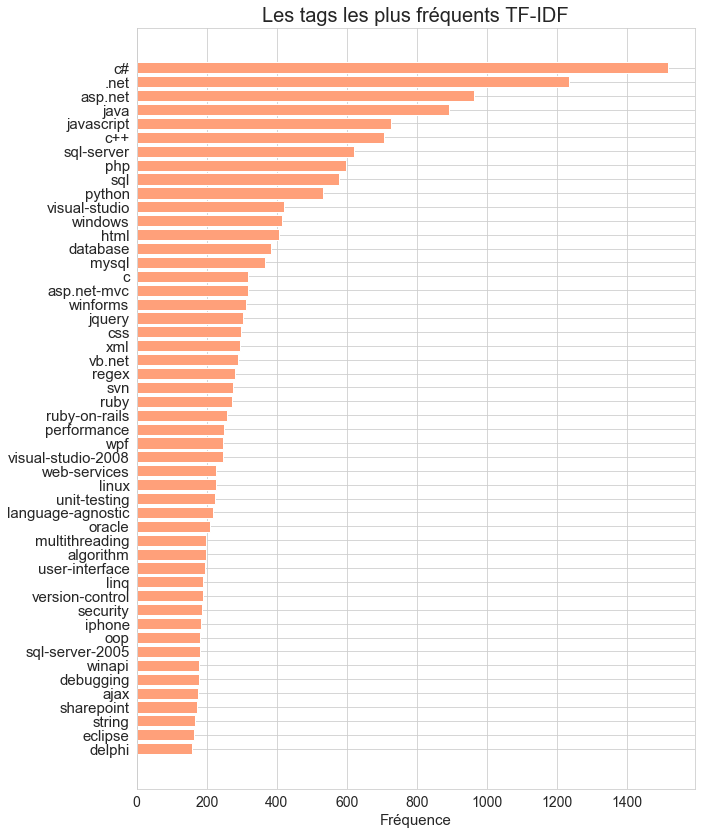

In [111]:
freq_target_50 = freq_target[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='lightsalmon', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

Nous constatons seulement légères différences par rapport à la méthode bag of words.

#### Sauvegarder les données

In [112]:
np.save('Data/X_train_tfidf', X_train_tfidf)
np.save('Data/X_train_vocab_tfidf', X_train_vocab_tfidf)
np.save('Data/X_train_dist_tfidf', X_train_dist_tfidf)
np.save('Data/y_train_tfidf', y_train_tfidf)
np.save('Data/y_train_vocab_tfidf', y_train_vocab_tfidf)
np.save('Data/y_train_dist_tfidf', y_train_dist_tfidf)

## Analyses multivariées 

In [ ]:
# !!! ???

## Réduction de dimension

### Word2vect


# Modélisation de flags basée sur les fréquences

## Fréquences BOW

Nous allons mettre en oeuvre une méthode basée uniquement sur les fréquences des expressions (mot / bigram) utilisées dans le post et nous allons regarder si les expressions les plus fréquentes apparaissent dans le vocabulaire de tags.

Tout d'abord, nous allons analyser s'il existe un ou plusieurs expressions, présentes au moins deux fois dans chaque post, qui matchent avec le vocabulaire de tags. 

Nous allons utiliser la décomposition en Bag of words créé dans le chaître 6.1.2 :

In [114]:
#The tags vocabulary :
y_train_vocab_bow[:10]

['.emf',
 '.htaccess',
 '.htpasswd',
 '.net',
 '.net-1.0',
 '.net-1.1',
 '.net-2.0',
 '.net-3.0',
 '.net-3.5',
 '.net-4.0']

In [115]:
#The features vocabulary : 
X_train_vocab_bow[:10]

['##',
 '###',
 '####',
 '#####################################################################',
 '##dispatcher',
 '#-#',
 '#-1',
 '#-bin',
 '#-class',
 '#-code']

In [116]:
#The BOW array :
X_train_bow[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Tester les fonctions sur le premier post

Nous allons tester notre idée sur le premier post.

In [117]:
BOW_post1 = X_train_bow[0]
BOW_post1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [119]:
#We print all expressions which are at least 2 times in the post :
for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        print (freq, word)

2 authentication
2 based
2 best
2 permissions
2 plug
2 rails
2 role
2 role-based


In [120]:
#We compare the frequent expression to the tag's vocab:

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            print(word)


authentication
permissions
role


In [121]:
predicted_tags_vect = []

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            predicted_tags_vect.append(word)

predicted_tags_vect

['authentication', 'permissions', 'role']

### Création d'une fonction à appliquer sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [122]:
def pred_tag_freq(BOW, vocabulary, list_of_tags):
    
    """Function which generates a list of tags, based on frequency of expression in a BOW object and 
    its comparison to predefined list of tags.
    
    Input :
    - BOW : a BOW array
    - vocabulary : list of BOW vocabulary
    - list_of_tags : a list of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for vect in range(BOW.shape[0]): 
        
        predicted_tags_vect = [] 
        
        for freq, word in zip(BOW[vect], vocabulary):
            
            if freq >= 2:
                if word in list_of_tags:
                    predicted_tags_vect.append(word)
                    
        predicted_tags.append(predicted_tags_vect)
        
    return predicted_tags


In [123]:
predicted_tags = pred_tag_freq(X_train_bow, X_train_vocab_bow, y_train_vocab_bow)

In [124]:
len(predicted_tags)

35000

In [125]:
predicted_tags[:10]

[['authentication', 'permissions', 'role'],
 ['console', 'platform', 'vb6', 'windows'],
 ['inverse', 'line', 'lines', 'match', 'regex'],
 ['virtual'],
 ['config', 'jar', 'osgi', 'web', 'xml'],
 ['api', 'broadcast', 'live', 'webcam'],
 ['field', 'limit', 'photo', 'photos', 'project', 'record'],
 ['com', 'dcom'],
 ['ajax', 'post'],
 ['com', 'file', 'python']]

Sauvegarder les tags prédits:

In [127]:
#Save the predicted tags:
np.save('Data/predicted_tags', predicted_tags)

Nous allons analyser le nombre de tag prédits par la méthode :

In [134]:
nbr_tags = []

for tag in range(len(predicted_tags)):
    length = len(predicted_tags[tag])
    nbr_tags.append(length)
    
nbr_tags = DataFrame(nbr_tags)

In [146]:
nbr_tags[0].value_counts()

2     6098
3     5696
1     4552
4     4542
5     3516
6     2387
0     1875
7     1641
8     1200
9      876
10     630
11     443
12     353
13     233
14     181
15     157
16     119
17     100
18      75
19      66
20      43
22      38
21      31
23      22
24      20
25      17
26      17
27      11
28      10
30       9
33       5
29       5
31       5
32       3
45       3
37       3
35       2
40       2
34       2
39       2
36       2
63       1
38       1
71       1
43       1
50       1
52       1
56       1
44       1
Name: 0, dtype: int64

Désavantage de la méthode : nous avons des posts sans tag attribué (1875 posts) et certains posts peuvent avoir un grand nombre de tags, même si c'est plutôt rare. Nous allons appliquer la même méthode avec TF-IDF et choisir 3 tags les plus fréquents basé sur le coefficient TF-IDF. 

## Fréquences TF-IDF

L'idée est d'utiliser les fréquences TF-IDF pour avoir la main sur le nombre de tags à prédire. Cette fois-ci, la méthode sera basé sur la procédure suivante :

1. Nous allons comparer toutes les expressions dans le post avec le vocabulaire de tags
2. Nous allons attribuer à chaque expression la distance relative TF-IDF de tag
3. Nous allons sortir 3 tags les plus fréquents

In [147]:
y_train_dist_tfidf[:10]

array([1.29137083e+00, 2.03157824e+01, 1.77910765e+00, 1.23469745e+03,
       7.61972597e-01, 1.03923973e+01, 1.00032151e+02, 5.74763060e+00,
       1.16193175e+02, 2.80201636e+00])

### Tester les fonctions sur le premier post

In [148]:
#Extract the array of first post
TFIDF_post1 = X_train_tfidf[0]
TFIDF_post1

array([0., 0., 0., ..., 0., 0., 0.])

In [149]:
#We compare the expressions in the post to the tag's vocab:
for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            print(word)

add
authentication
handle
permissions
plugins
restful-authentication
role
using


In [175]:
#We list the common expressions which are in both document and the tag's vocabulary:

liste_tags = []

for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            liste_tags.append(word)

In [176]:
liste_tags

['add',
 'authentication',
 'handle',
 'permissions',
 'plugins',
 'restful-authentication',
 'role',
 'using']

In [177]:
#We zip the list with tag's relative frequency:

for freq, word in zip(y_train_dist_tfidf, liste_tags):
    print(freq, word)

1.2913708286761647 add
20.315782399608562 authentication
1.779107648085159 handle
1234.6974528795652 permissions
0.7619725969000765 plugins
10.392397318668808 restful-authentication
100.03215112054504 role
5.747630599165471 using


In [178]:
#Zip the tags contained in the post and tag's frequency
liste = zip(y_train_dist_tfidf, liste_tags)

In [180]:
#Converting to list
liste = list(liste)

In [181]:
#Check
liste

[(1.2913708286761647, 'add'),
 (20.315782399608562, 'authentication'),
 (1.779107648085159, 'handle'),
 (1234.6974528795652, 'permissions'),
 (0.7619725969000765, 'plugins'),
 (10.392397318668808, 'restful-authentication'),
 (100.03215112054504, 'role'),
 (5.747630599165471, 'using')]

In [185]:
#Sort the list by frequency
liste_sort = sorted(liste, key = lambda x: x[0])

In [186]:
#Check
liste_sort

[(0.7619725969000765, 'plugins'),
 (1.2913708286761647, 'add'),
 (1.779107648085159, 'handle'),
 (5.747630599165471, 'using'),
 (10.392397318668808, 'restful-authentication'),
 (20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [193]:
#Extract 3 most frequent tags 
tags_final = liste_sort[-3:]

In [194]:
tags_final

[(20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [195]:
#Extract the tag's name
tags = [x[1] for x in tags_final]

In [196]:
tags

['authentication', 'role', 'permissions']

### Appliquer la fonctions sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [198]:
# At first, we will test the function on a sample
test_sample = X_train_tfidf[:100]

In [199]:
test_sample.shape

(100, 50000)

In [200]:
def pred_tag_tfidf(tfidf_array, tfidf_vocabulary, list_of_tags):
    
    """Function generatig a list of tags, based on frequency of expression in an TF-IDF object and 
    its comparison to predefined list of tags. 
    
    Is the document contains more than 3 common expressions with the list of tags, the tags are sorted by the 
    TF-IDF frequency and only 3 most common tags are the predicted tags. If the document contains 
    2 or less common expressions, all the expressions are considered comme predicted tags. 
        
    Input :
    - tfidf_array : a TF-IDF array
    - tfidf_vocabulary : a TF-IDF vocabulary object
    - list_of_tags : a list of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for doc in range(tfidf_array.shape[0]): 
       
        #We list the common expressions which are in both document and the tag's vocabulary:   
    
        liste_tags = []

        for freq, word in zip(tfidf_array[doc], tfidf_vocabulary):
            if freq > 0:
                if word in list_of_tags:
                    liste_tags.append(word)
                    
        
    
    predicted_tags.append(liste_tags)
    
    return predicted_tags

In [201]:
# !!! Regarder la fct précédente, le même pb. Indentation ???
pred_tag_tfidf(test_sample, X_train_vocab_tfidf, y_train_vocab_tfidf)

[['c#', 'file', 'fixed', 'fixed-width', 'width']]

In [177]:
#We zip the list with tag's relative frequency:

for freq, word in zip(y_train_dist_tfidf, liste_tags):
    print(freq, word)

1.2913708286761647 add
20.315782399608562 authentication
1.779107648085159 handle
1234.6974528795652 permissions
0.7619725969000765 plugins
10.392397318668808 restful-authentication
100.03215112054504 role
5.747630599165471 using


In [178]:
#Zip the tags contained in the post and tag's frequency
liste = zip(y_train_dist_tfidf, liste_tags)

In [180]:
#Converting to list
liste = list(liste)

In [181]:
#Check
liste

[(1.2913708286761647, 'add'),
 (20.315782399608562, 'authentication'),
 (1.779107648085159, 'handle'),
 (1234.6974528795652, 'permissions'),
 (0.7619725969000765, 'plugins'),
 (10.392397318668808, 'restful-authentication'),
 (100.03215112054504, 'role'),
 (5.747630599165471, 'using')]

In [185]:
#Sort the list by frequency
liste_sort = sorted(liste, key = lambda x: x[0])

In [186]:
#Check
liste_sort

[(0.7619725969000765, 'plugins'),
 (1.2913708286761647, 'add'),
 (1.779107648085159, 'handle'),
 (5.747630599165471, 'using'),
 (10.392397318668808, 'restful-authentication'),
 (20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [193]:
#Extract 3 most frequent tags 
tags_final = liste_sort[-3:]

In [194]:
tags_final

[(20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [195]:
#Extract the tag's name
tags = [x[1] for x in tags_final]

In [196]:
tags

['authentication', 'role', 'permissions']

# Modélisation non supervisée

## LDA

In [98]:
from sklearn.decomposition import LatentDirichletAllocation

In [99]:
no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5,
                                learning_method='online', learning_offset=50., random_state=0).fit(train_data_features)

In [121]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

display_topics(lda, vocab, no_top_words)

Topic 0
file files server service web using data application command directory
Topic 1
net web page asp asp-net system mvc button assembly 2-0
Topic 2
visual studio visual-studio 2008 ruby lib 8 rails c usr
Topic 3
control end value controls sub vb binding option wpf grid
Topic 4
c date thread 00 10 time 2008 +-+ 11 datetime
Topic 5
class public object string new return method int type value
Topic 6
way like want get using list something function need one
Topic 7
input delphi end begin frame '-' quotes oriented points font-color
Topic 8
print 1) 2) values constant printing (1 3) compare 45
Topic 9
javascript asp form page jquery script id type server ajax
Topic 10
div html image text css style svn width font color
Topic 11
memory search performance index large process size time services much
Topic 12
user python url request http site response # page get
Topic 13
use like code using one know way application project need
Topic 14
sql table database id query data select name sql-server se